## 1 - Data 

In [1]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import datetime
import nltk
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import yfinance as yf
import time
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [2]:
comments_data = pd.read_csv("/Users/marco/Library/CloudStorage/OneDrive-ErasmusUniversityRotterdam/University - OD/EUR/MSc Thesis/Data/stocktwits_data.csv")
comments_data

,ticker,id,created_at,user,body
0,MMM,574948072,2024-05-31 22:07:52,TheClockworkGroup,"$MMM #NYSE | The markets are unpredictable, bu..."
1,MMM,574928917,2024-05-31 19:37:27,fishinNbanjo,"$MMM wow, that went to hell"
2,MMM,574915317,2024-05-31 18:13:34,RustyToo,$MMM Hear directly from the 3M scientist who w...
3,MMM,574908409,2024-05-31 17:30:20,LiveTradePro,$QQQ Setup confirmed All about follow through...
4,MMM,574908274,2024-05-31 17:29:31,DeepFknValue,@cajunman I was in $MMM preCovid and it just h...
...,...,...,...,...,...
1086042,NVDA,559107987,2024-01-25 00:13:30,Pianonymous,@dracorx What $NVDA bulls are feeling now is w...
1086043,NVDA,559107525,2024-01-25 00:09:20,CharlesXBrown,$LAES $NVDA Is it 12 or 15? Im good either way
1086044,NVDA,559107201,2024-01-25 00:06:21,SonGoku,Nothing is too oversold $TSLA \n\nNothing is t...
1086045,NVDA,559106977,2024-01-25 00:04:15,AthleticBeing,That’s how we trust our conviction and go agai...


In [3]:
comments_data = comments_data.dropna(subset=['created_at', 'ticker', 'body', 'user'])
print(comments_data.isnull().sum())  

ticker        0
id            0
created_at    0
user          0
body          0
dtype: int64


In [4]:
comments_data['created_at'] = pd.to_datetime(comments_data['created_at'])
comments_data

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_85614/2117105917.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_data['created_at'] = pd.to_datetime(comments_data['created_at'])


,ticker,id,created_at,user,body
0,MMM,574948072,2024-05-31 22:07:52,TheClockworkGroup,"$MMM #NYSE | The markets are unpredictable, bu..."
1,MMM,574928917,2024-05-31 19:37:27,fishinNbanjo,"$MMM wow, that went to hell"
2,MMM,574915317,2024-05-31 18:13:34,RustyToo,$MMM Hear directly from the 3M scientist who w...
3,MMM,574908409,2024-05-31 17:30:20,LiveTradePro,$QQQ Setup confirmed All about follow through...
4,MMM,574908274,2024-05-31 17:29:31,DeepFknValue,@cajunman I was in $MMM preCovid and it just h...
...,...,...,...,...,...
1086042,NVDA,559107987,2024-01-25 00:13:30,Pianonymous,@dracorx What $NVDA bulls are feeling now is w...
1086043,NVDA,559107525,2024-01-25 00:09:20,CharlesXBrown,$LAES $NVDA Is it 12 or 15? Im good either way
1086044,NVDA,559107201,2024-01-25 00:06:21,SonGoku,Nothing is too oversold $TSLA \n\nNothing is t...
1086045,NVDA,559106977,2024-01-25 00:04:15,AthleticBeing,That’s how we trust our conviction and go agai...


### 1.2 Variables Definition

Together with sentiment scores, it's crucial to define other "assistance" variables that may improve the performance of this Stock-Twits factor. Common variabels in social-media studies are attention measures. The design of these attention measures is this study was inspired by the ones defined in [Cookson et al. (2023)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4241505), and then adapted to match Stocktwits attention measures. 

#### Attention Measures

To create an attention measure, we first need to extract the dates and remove the time of creation of the post, in order to pool together posts beloning to the same date.

Then the following variables are created:

* **M_vol** = number of messages per firm per day 
* **Avg_M_firm/d** = average daily message volume per ticker across the whole period
* **M_tot/d** = total messages per day, across al firms 
* **A_Cookson** = attention measure as defined in [Cookson et al. (2023)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4241505). 
* **A_rel** = relative attention measure, computed as the ticker daily message volume over the average daily message volume of that ticker across the whole time frame.

All the variables are then stored in the dataframe: *attention_measures*

In [5]:
comments_data['date'] = pd.to_datetime(comments_data['created_at'].dt.date)

start_date = comments_data['date'].min()
end_date = comments_data['date'].max()
full_date_range = pd.date_range(start=start_date, end=end_date)

all_tickers = comments_data['ticker'].unique()

complete_index = pd.MultiIndex.from_product([all_tickers, full_date_range], names=['ticker', 'date'])
attention_measures = pd.DataFrame(index=complete_index).reset_index()
attention_measures['M_vol'] = 0

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_85614/1979002454.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_data['date'] = pd.to_datetime(comments_data['created_at'].dt.date)


In [6]:
message_volume = comments_data.groupby(['ticker', 'date']).size().reset_index(name='M_vol')
attention_measures = attention_measures.merge(message_volume, on=['ticker', 'date'], how='left')
attention_measures['M_vol'] = attention_measures['M_vol_y'].fillna(0).astype(int)
attention_measures.drop(columns=['M_vol_x', 'M_vol_y'], inplace=True)

In [7]:
tot_messages = comments_data.groupby('date').size().reset_index(name='M_tot/d')
attention_measures = attention_measures.merge(tot_messages, on='date')

attention_measures['A_Cookson'] = np.where(
    attention_measures['M_vol'] == 0,
    np.nan,  
    attention_measures['M_vol'] / attention_measures['M_tot/d']
)

In [8]:
message_volume = attention_measures[['M_vol', 'ticker']]
average_daily_message_volume = message_volume.groupby('ticker')['M_vol'].mean().reset_index(name='Avg_M_firm/d')
attention_measures = attention_measures.merge(average_daily_message_volume, on='ticker')
attention_measures['A_rel'] = attention_measures['M_vol'] / attention_measures['Avg_M_firm/d']

Given the formulation of the A_Cookson variable ($\frac{Messages_{i,t}}{Messages_t}$), a zero is inserted when there are no messages for firm i on day t in order to avoid missing values.

In [9]:
attention_measures['A_Cookson'] = attention_measures['A_Cookson'].fillna(0)
attention_measures

,ticker,date,M_vol,M_tot/d,A_Cookson,Avg_M_firm/d,A_rel
0,MMM,2024-01-01,4,707,0.005658,16.782895,0.238338
1,MMM,2024-01-02,9,5731,0.001570,16.782895,0.536260
2,MMM,2024-01-03,10,5542,0.001804,16.782895,0.595845
3,MMM,2024-01-04,6,6104,0.000983,16.782895,0.357507
4,MMM,2024-01-05,3,5824,0.000515,16.782895,0.178753
...,...,...,...,...,...,...,...
76299,NVDA,2024-05-27,379,1311,0.289092,1451.098684,0.261181
76300,NVDA,2024-05-28,4915,10814,0.454503,1451.098684,3.387089
76301,NVDA,2024-05-29,4292,11793,0.363945,1451.098684,2.957759
76302,NVDA,2024-05-30,3357,12780,0.262676,1451.098684,2.313420


The attention measures created can be vizualized in a chart like the following:

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_85614/3185434913.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  line1, = ax1.plot(ticker_data.index, ticker_data['A_Cookson'], 'bo', label='Attention', color='royalblue')


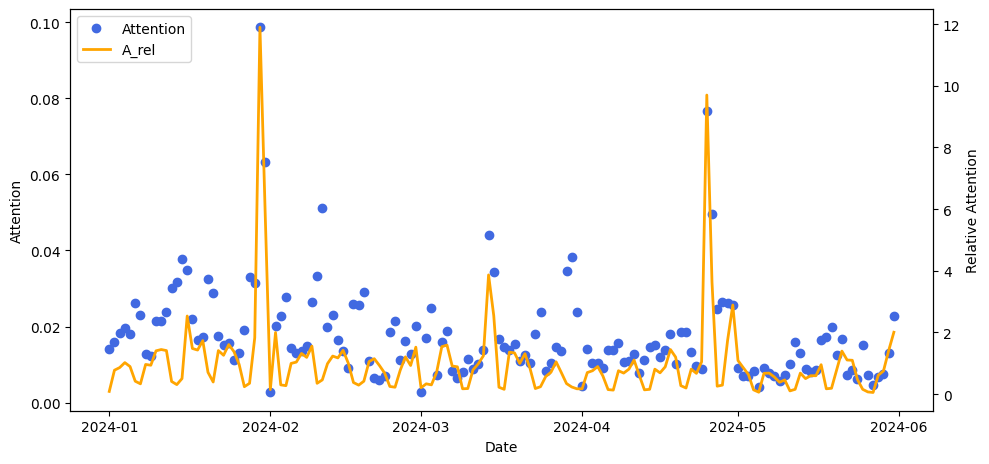

In [10]:
ticker = 'MSFT'

ticker_data = attention_measures[attention_measures['ticker'] == ticker]
ticker_data.set_index('date', inplace=True)
fig, ax1 = plt.subplots(figsize=(10, 5))

line1, = ax1.plot(ticker_data.index, ticker_data['A_Cookson'], 'bo', label='Attention', color='royalblue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Attention')
ax1.tick_params(axis='y', colors='black')

ax2 = ax1.twinx()
line2, = ax2.plot(ticker_data.index, ticker_data['A_rel'], label='Relative Attention', color='orange', linestyle='-', linewidth=2)
ax2.set_ylabel('Relative Attention')
ax2.tick_params(axis='y', colors='black')

fig.legend([line1, line2], ['Attention', 'A_rel'], loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### 1.3 - VADER Sentiment Analysis 

In [11]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/marco/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [12]:
test = comments_data['body'][5]
test

'$MMM 3M is a corrupt and unethical company. Careful.'

In [13]:
sia.polarity_scores(test)

{'neg': 0.303, 'neu': 0.55, 'pos': 0.147, 'compound': -0.4019}

In [14]:
res = {}
for i, row in tqdm(comments_data.iterrows(), total=len(comments_data)):
    text = row['body']
    com_id = row['id']
    res[com_id] = sia.polarity_scores(text)
#takes approx. 2 min to complete

  0%|          | 0/1084175 [00:00<?, ?it/s]

In [15]:
vader = pd.DataFrame(res).T
vader = vader.reset_index().rename(columns={'index': 'id'})
vader = vader.merge(comments_data, how='left')

In [16]:
vader

,id,neg,neu,pos,compound,ticker,created_at,user,body,date
0,574948072,0.000,0.796,0.204,0.8881,MMM,2024-05-31 22:07:52,TheClockworkGroup,"$MMM #NYSE | The markets are unpredictable, bu...",2024-05-31
1,574928917,0.371,0.323,0.306,-0.2023,MMM,2024-05-31 19:37:27,fishinNbanjo,"$MMM wow, that went to hell",2024-05-31
2,574915317,0.038,0.962,0.000,-0.4404,MMM,2024-05-31 18:13:34,RustyToo,$MMM Hear directly from the 3M scientist who w...,2024-05-31
3,574908409,0.000,1.000,0.000,0.0000,MMM,2024-05-31 17:30:20,LiveTradePro,$QQQ Setup confirmed All about follow through...,2024-05-31
4,574908274,0.000,1.000,0.000,0.0000,MMM,2024-05-31 17:29:31,DeepFknValue,@cajunman I was in $MMM preCovid and it just h...,2024-05-31
...,...,...,...,...,...,...,...,...,...,...
1084170,559107987,0.000,0.824,0.176,0.2500,NVDA,2024-01-25 00:13:30,Pianonymous,@dracorx What $NVDA bulls are feeling now is w...,2024-01-25
1084171,559107525,0.000,0.775,0.225,0.4404,NVDA,2024-01-25 00:09:20,CharlesXBrown,$LAES $NVDA Is it 12 or 15? Im good either way,2024-01-25
1084172,559107201,0.000,1.000,0.000,0.0000,NVDA,2024-01-25 00:06:21,SonGoku,Nothing is too oversold $TSLA \n\nNothing is t...,2024-01-25
1084173,559106977,0.107,0.737,0.156,0.5080,NVDA,2024-01-25 00:04:15,AthleticBeing,That’s how we trust our conviction and go agai...,2024-01-25


### 1.4 - RoBERTa Sentiment Analysis

In [17]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [18]:
chunk_size = len(comments_data) // 10  # Split into 10 chunks
chunks = [comments_data[i:i + chunk_size] for i in range(0, len(comments_data), chunk_size)]

In [19]:
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [20]:
# Run for Roberta Model
encoded_text = tokenizer(test, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
}

print(scores_dict)

{'roberta_neg': 0.9412956, 'roberta_neu': 0.054977484, 'roberta_pos': 0.0037268766}


In [21]:
def polarity_scores_roberta(test):
    encoded_text = tokenizer(test, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [22]:
def process_chunk(chunk, chunk_number):
    res = {}
    for i, row in tqdm(chunk.iterrows(), total=len(chunk)):
        try:
            text = row['body']
            com_id = row['id']
            roberta_result = polarity_scores_roberta(text)
            res[com_id] = roberta_result
        except RuntimeError:
            print(f'Broke for id {com_id}')

    result_df = pd.DataFrame.from_dict(res, orient='index')
    result_df.reset_index(inplace=True)
    result_df.rename(columns={'index': 'id'}, inplace=True)

    result_df.to_csv(f'sentiment_results_chunk_{chunk_number}.csv', index=False)
    print(f'Chunk {chunk_number} processed and saved.')

In [23]:
chunk_number = 10  # Specify which chunk to process
process_chunk(chunks[chunk_number], chunk_number)
# Takes 4hrs per chunk -> approximately 40hrs total.

  0%|          | 0/5 [00:00<?, ?it/s]

Chunk 10 processed and saved.


During the roBERTa sentiment analysis, some comments were not successfully processed. Given the low number (240 comments), those were excluded from the dataset.

Now the sentiment analysys results obtained from nltk and roBerta are combined in a sigle data frame to then create variables and start modeling:

In [24]:
l = list(range(0, 11))

data_frames = {}

for i in l:
    data_frames[f'chunk_{i}'] = pd.read_csv(f'/Users/marco/Library/CloudStorage/OneDrive-ErasmusUniversityRotterdam/University - OD/EUR/MSc Thesis/Data/sentiment_results_chunk_{i}.csv')

roberta_sentiment = pd.concat(data_frames.values(), ignore_index=True)

In [25]:
sentiment_data = roberta_sentiment.merge(vader, how='left')
sentiment_data

,id,roberta_neg,roberta_neu,roberta_pos,neg,neu,pos,compound,ticker,created_at,user,body,date
0,574948072,0.003141,0.092694,0.904165,0.000,0.796,0.204,0.8881,MMM,2024-05-31 22:07:52,TheClockworkGroup,"$MMM #NYSE | The markets are unpredictable, bu...",2024-05-31
1,574928917,0.941562,0.051395,0.007044,0.371,0.323,0.306,-0.2023,MMM,2024-05-31 19:37:27,fishinNbanjo,"$MMM wow, that went to hell",2024-05-31
2,574915317,0.704376,0.267132,0.028492,0.038,0.962,0.000,-0.4404,MMM,2024-05-31 18:13:34,RustyToo,$MMM Hear directly from the 3M scientist who w...,2024-05-31
3,574908409,0.003834,0.478237,0.517929,0.000,1.000,0.000,0.0000,MMM,2024-05-31 17:30:20,LiveTradePro,$QQQ Setup confirmed All about follow through...,2024-05-31
4,574908274,0.043001,0.863248,0.093751,0.000,1.000,0.000,0.0000,MMM,2024-05-31 17:29:31,DeepFknValue,@cajunman I was in $MMM preCovid and it just h...,2024-05-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1083930,559107987,0.039442,0.748142,0.212416,0.000,0.824,0.176,0.2500,NVDA,2024-01-25 00:13:30,Pianonymous,@dracorx What $NVDA bulls are feeling now is w...,2024-01-25
1083931,559107525,0.006342,0.156151,0.837507,0.000,0.775,0.225,0.4404,NVDA,2024-01-25 00:09:20,CharlesXBrown,$LAES $NVDA Is it 12 or 15? Im good either way,2024-01-25
1083932,559107201,0.384766,0.536835,0.078398,0.000,1.000,0.000,0.0000,NVDA,2024-01-25 00:06:21,SonGoku,Nothing is too oversold $TSLA \n\nNothing is t...,2024-01-25
1083933,559106977,0.005367,0.115389,0.879243,0.107,0.737,0.156,0.5080,NVDA,2024-01-25 00:04:15,AthleticBeing,That’s how we trust our conviction and go agai...,2024-01-25


#### Sentiment Measures

An overall sentiment meaures is computed as:

$positive\ score_{i,t} + 0 \times neutral\ score_{i,t} - negative\ score_{i,t}$ 

which simplifies to:

\begin{equation}
     positive\ score_{i,t} - negative\ score_{i,t}
\end{equation}

for both vader and roberta values, in order to have a comprehensive sentiment measures that will facilitate the sorting process in the portfolio strategy.

In [26]:
sentiment_data['roberta_S'] = sentiment_data['roberta_pos'] - sentiment_data['roberta_neg']
sentiment_data['vader_S'] = sentiment_data['pos'] - sentiment_data['neg']

In [27]:
sentiment_data

,id,roberta_neg,roberta_neu,roberta_pos,neg,neu,pos,compound,ticker,created_at,user,body,date,roberta_S,vader_S
0,574948072,0.003141,0.092694,0.904165,0.000,0.796,0.204,0.8881,MMM,2024-05-31 22:07:52,TheClockworkGroup,"$MMM #NYSE | The markets are unpredictable, bu...",2024-05-31,0.901024,0.204
1,574928917,0.941562,0.051395,0.007044,0.371,0.323,0.306,-0.2023,MMM,2024-05-31 19:37:27,fishinNbanjo,"$MMM wow, that went to hell",2024-05-31,-0.934518,-0.065
2,574915317,0.704376,0.267132,0.028492,0.038,0.962,0.000,-0.4404,MMM,2024-05-31 18:13:34,RustyToo,$MMM Hear directly from the 3M scientist who w...,2024-05-31,-0.675884,-0.038
3,574908409,0.003834,0.478237,0.517929,0.000,1.000,0.000,0.0000,MMM,2024-05-31 17:30:20,LiveTradePro,$QQQ Setup confirmed All about follow through...,2024-05-31,0.514095,0.000
4,574908274,0.043001,0.863248,0.093751,0.000,1.000,0.000,0.0000,MMM,2024-05-31 17:29:31,DeepFknValue,@cajunman I was in $MMM preCovid and it just h...,2024-05-31,0.050750,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1083930,559107987,0.039442,0.748142,0.212416,0.000,0.824,0.176,0.2500,NVDA,2024-01-25 00:13:30,Pianonymous,@dracorx What $NVDA bulls are feeling now is w...,2024-01-25,0.172975,0.176
1083931,559107525,0.006342,0.156151,0.837507,0.000,0.775,0.225,0.4404,NVDA,2024-01-25 00:09:20,CharlesXBrown,$LAES $NVDA Is it 12 or 15? Im good either way,2024-01-25,0.831164,0.225
1083932,559107201,0.384766,0.536835,0.078398,0.000,1.000,0.000,0.0000,NVDA,2024-01-25 00:06:21,SonGoku,Nothing is too oversold $TSLA \n\nNothing is t...,2024-01-25,-0.306368,0.000
1083933,559106977,0.005367,0.115389,0.879243,0.107,0.737,0.156,0.5080,NVDA,2024-01-25 00:04:15,AthleticBeing,That’s how we trust our conviction and go agai...,2024-01-25,0.873876,0.049


In [28]:
to_drop = ['id', 'user', 'body', 'created_at', 'ticker', 'date']
columns = [i for i in list(sentiment_data.columns) if i not in to_drop]

daily_sentiment = sentiment_data.groupby(['ticker', 'date'])[columns].mean().reset_index()
daily_sentiment

,ticker,date,roberta_neg,roberta_neu,roberta_pos,neg,neu,pos,compound,roberta_S,vader_S
0,A,2024-01-01,0.019773,0.562884,0.417344,0.0000,0.7810,0.2190,0.63690,0.397571,0.2190
1,A,2024-01-04,0.269511,0.553767,0.176721,0.0000,1.0000,0.0000,0.00000,-0.092790,0.0000
2,A,2024-01-05,0.281703,0.678933,0.039364,0.0540,0.8804,0.0656,0.09600,-0.242340,0.0116
3,A,2024-01-06,0.025090,0.906964,0.067947,0.0000,1.0000,0.0000,0.00000,0.042857,0.0000
4,A,2024-01-07,0.015686,0.800739,0.183575,0.0000,0.7920,0.2080,0.63690,0.167889,0.2080
...,...,...,...,...,...,...,...,...,...,...,...
42274,ZTS,2024-05-24,0.050144,0.323142,0.626715,0.0305,0.8040,0.1655,0.45435,0.576571,0.1350
42275,ZTS,2024-05-25,0.284887,0.641280,0.073833,0.0000,0.9240,0.0760,0.31820,-0.211054,0.0760
42276,ZTS,2024-05-28,0.138578,0.751024,0.110398,0.0000,1.0000,0.0000,0.00000,-0.028180,0.0000
42277,ZTS,2024-05-29,0.080666,0.726350,0.192984,0.0000,0.9275,0.0725,0.14800,0.112318,0.0725


#### Social Media Dataset - Variables

In [29]:
social_media_data = pd.merge(attention_measures, daily_sentiment, on=['ticker', 'date'], how='left')

**Note:** 

There are a few important considerations regarding the dataframes and time spans used. From January 1st to May 31st, there are 153 days, which, when multiplied by the 502 tickers, totals 76,304 observations in the attention measures dataset. However, not all companies receive comments every day—some have zero comments on certain days—resulting in a smaller daily sentiment dataset with 42,279 observations. This discrepancy is due to the aforementioned reason. Additionally, the next section references 51,876 observations because only 106 of the 153 days are trading days with available stock market and returns data.

### 1.5 - Importing Financial Data

Note that *GE Vervnova Inc* (GEV) and *Solventum Corp* (SOLV) have specific situations:

* GEV spineed-off from GE in April, meaning that it's a new stock with no price data until April.
* SOLV IPOd in April

There is no data covering the full time period for these two companies, but given that the twits match their price data, they will still be included in the analysis, while taking into account that there is only one month of data available.

In [30]:
tickers = list(comments_data['ticker'].unique())
tickers.remove('BRK.B')
tickers.remove('BF.B')

start_date = '2023-12-28'
end_date = '2024-06-01'

def get_data(ticker_subset):
    prices = yf.download(ticker_subset, start=start_date, end=end_date)
    adj_close = prices['Adj Close']
    returns = adj_close.pct_change()
    returns_long = returns.reset_index().melt(id_vars='Date', var_name='ticker', value_name='ret')
    return returns_long

rets = get_data(tickers)
rets = rets.dropna()
rets.rename(columns={'Date': 'date'}, inplace=True)

[*********************100%%**********************]  500 of 500 completed

1 Failed download:
['WRK']: Exception('%ticker%: No data found, symbol may be delisted')
/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_85614/3604968282.py:11: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = adj_close.pct_change()


In [31]:
MSFT = yf.download('MSFT', start=start_date, end=end_date)
(MSFT['High'] - MSFT['Low']).mean()

[*********************100%%**********************]  1 of 1 completed


6.440374926985982

In [32]:
A = yf.download('A', start=start_date, end=end_date)
(A['High'] - A['Low']).mean()

[*********************100%%**********************]  1 of 1 completed


3.0422433157947575

### 1.6 Fama-French Data

Fama-French factor data is necessary in this reasearch mainly to evaluate 3- and 5-factor alpha when operating with portfolio sorts. In that way it is possible to evaluate the risk-adjusted returns of the StockTwits factor. However, they are also necessary to compute excess retursn, as the FF-dataframe also includes data for the risk-free rate *$r_f$*. 

*The data was downloaded from the [Fama-French data library](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)*.

In [33]:
FF_data = pd.read_csv("/Users/marco/Library/CloudStorage/OneDrive-ErasmusUniversityRotterdam/University - OD/EUR/MSc Thesis/Data/F&F_data.csv", header=2)
FF_data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
FF_data['date'] = pd.to_datetime(FF_data['date'], format='%Y%m%d')
FF_data = FF_data[(FF_data['date'] >= '2023-12-29') & (FF_data['date'] <= '2024-05-31')]

to_divide = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
for i in to_divide:
    FF_data[i] = FF_data[i]/100
FF_data

,date,Mkt-RF,SMB,HML,RMW,CMA,RF
15228,2023-12-29,-0.0043,-0.0113,-0.0037,0.0068,-0.0007,0.00021
15229,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.00022
15230,2024-01-03,-0.0101,-0.0194,-0.0011,0.0033,-0.0018,0.00022
15231,2024-01-04,-0.0033,0.0024,0.0009,-0.0041,0.0024,0.00022
15232,2024-01-05,0.0015,-0.0059,0.0064,0.0011,-0.0015,0.00022
...,...,...,...,...,...,...,...
15329,2024-05-24,0.0072,0.0017,0.0016,0.0031,-0.0039,0.00020
15330,2024-05-28,-0.0004,0.0010,-0.0089,0.0005,-0.0112,0.00020
15331,2024-05-29,-0.0077,-0.0039,-0.0062,0.0048,-0.0002,0.00020
15332,2024-05-30,-0.0053,0.0136,0.0099,0.0034,0.0107,0.00020


In [34]:
research_data = pd.merge(FF_data, social_media_data, on='date', how='left')
research_data = pd.merge(research_data, rets, on=['date', 'ticker'], how='left')
research_data

,date,Mkt-RF,SMB,HML,RMW,CMA,RF,ticker,M_vol,M_tot/d,...,roberta_neg,roberta_neu,roberta_pos,neg,neu,pos,compound,roberta_S,vader_S,ret
0,2023-12-29,-0.0043,-0.0113,-0.0037,0.0068,-0.0007,0.00021,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.00022,MMM,9.0,5731.0,...,0.081047,0.669640,0.249313,0.053222,0.800111,0.146667,0.155311,0.168266,0.093444,0.006220
2,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.00022,AOS,2.0,5731.0,...,0.374486,0.572005,0.053510,0.191500,0.808500,0.000000,-0.238350,-0.320976,-0.191500,-0.012130
3,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.00022,ABT,4.0,5731.0,...,0.156287,0.647608,0.196105,0.000000,0.948000,0.052000,0.159225,0.039818,0.052000,-0.001999
4,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.00022,ABBV,22.0,5731.0,...,0.056310,0.704331,0.239359,0.006227,0.906909,0.086818,0.153368,0.183050,0.080591,0.031296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52706,2024-05-31,0.0068,-0.0003,0.0078,0.0091,0.0080,0.00020,MSFT,236.0,10406.0,...,0.266645,0.501310,0.232045,0.092458,0.813492,0.094055,0.028573,-0.034601,0.001597,0.001109
52707,2024-05-31,0.0068,-0.0003,0.0078,0.0091,0.0080,0.00020,TSLA,1072.0,10406.0,...,0.274290,0.501777,0.223934,0.073376,0.841557,0.085062,0.026171,-0.050356,0.011686,-0.003971
52708,2024-05-31,0.0068,-0.0003,0.0078,0.0091,0.0080,0.00020,AMZN,483.0,10406.0,...,0.313564,0.478393,0.208043,0.097880,0.798602,0.103520,0.015593,-0.105522,0.005640,-0.016061
52709,2024-05-31,0.0068,-0.0003,0.0078,0.0091,0.0080,0.00020,GOOG,15.0,10406.0,...,0.242113,0.458476,0.299411,0.066533,0.852200,0.081267,0.104940,0.057298,0.014733,0.002305


### 1.7 Final Data Preprocessing

For this reasearch, only trading days will be taken into account due to the fact that return data is not available for non-trading days. This will lead to the exclusion of sentiment and attention measures derived from non-trading days, and to the simplifying assumptions that sentiment for fridays affects the returns on mondays for instance. 

In [35]:
research_data = research_data.dropna(subset='ret')
research_data['ret_nd'] = research_data.groupby('ticker')['ret'].shift(-1)
research_data

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_85614/3708917468.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  research_data['ret_nd'] = research_data.groupby('ticker')['ret'].shift(-1)


,date,Mkt-RF,SMB,HML,RMW,CMA,RF,ticker,M_vol,M_tot/d,...,roberta_neu,roberta_pos,neg,neu,pos,compound,roberta_S,vader_S,ret,ret_nd
1,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.00022,MMM,9.0,5731.0,...,0.669640,0.249313,0.053222,0.800111,0.146667,0.155311,0.168266,0.093444,0.006220,-0.020091
2,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.00022,AOS,2.0,5731.0,...,0.572005,0.053510,0.191500,0.808500,0.000000,-0.238350,-0.320976,-0.191500,-0.012130,-0.033522
3,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.00022,ABT,4.0,5731.0,...,0.647608,0.196105,0.000000,0.948000,0.052000,0.159225,0.039818,0.052000,-0.001999,-0.003004
4,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.00022,ABBV,22.0,5731.0,...,0.704331,0.239359,0.006227,0.906909,0.086818,0.153368,0.183050,0.080591,0.031296,0.004005
5,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.00022,ACN,1.0,5731.0,...,0.152763,0.843104,0.000000,1.000000,0.000000,0.000000,0.838971,0.000000,-0.011370,-0.025942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52706,2024-05-31,0.0068,-0.0003,0.0078,0.0091,0.0080,0.00020,MSFT,236.0,10406.0,...,0.501310,0.232045,0.092458,0.813492,0.094055,0.028573,-0.034601,0.001597,0.001109,NaN
52707,2024-05-31,0.0068,-0.0003,0.0078,0.0091,0.0080,0.00020,TSLA,1072.0,10406.0,...,0.501777,0.223934,0.073376,0.841557,0.085062,0.026171,-0.050356,0.011686,-0.003971,NaN
52708,2024-05-31,0.0068,-0.0003,0.0078,0.0091,0.0080,0.00020,AMZN,483.0,10406.0,...,0.478393,0.208043,0.097880,0.798602,0.103520,0.015593,-0.105522,0.005640,-0.016061,NaN
52709,2024-05-31,0.0068,-0.0003,0.0078,0.0091,0.0080,0.00020,GOOG,15.0,10406.0,...,0.458476,0.299411,0.066533,0.852200,0.081267,0.104940,0.057298,0.014733,0.002305,NaN


We are going to work with excess returns, which will be computed by subtracting the risk-free rate RF from the ret column:

In [36]:
research_data['exc_ret'] = research_data['ret']-research_data['RF']
research_data

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_85614/1357720081.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  research_data['exc_ret'] = research_data['ret']-research_data['RF']


,date,Mkt-RF,SMB,HML,RMW,CMA,RF,ticker,M_vol,M_tot/d,...,roberta_pos,neg,neu,pos,compound,roberta_S,vader_S,ret,ret_nd,exc_ret
1,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.00022,MMM,9.0,5731.0,...,0.249313,0.053222,0.800111,0.146667,0.155311,0.168266,0.093444,0.006220,-0.020091,0.006000
2,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.00022,AOS,2.0,5731.0,...,0.053510,0.191500,0.808500,0.000000,-0.238350,-0.320976,-0.191500,-0.012130,-0.033522,-0.012350
3,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.00022,ABT,4.0,5731.0,...,0.196105,0.000000,0.948000,0.052000,0.159225,0.039818,0.052000,-0.001999,-0.003004,-0.002219
4,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.00022,ABBV,22.0,5731.0,...,0.239359,0.006227,0.906909,0.086818,0.153368,0.183050,0.080591,0.031296,0.004005,0.031076
5,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.00022,ACN,1.0,5731.0,...,0.843104,0.000000,1.000000,0.000000,0.000000,0.838971,0.000000,-0.011370,-0.025942,-0.011590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52706,2024-05-31,0.0068,-0.0003,0.0078,0.0091,0.0080,0.00020,MSFT,236.0,10406.0,...,0.232045,0.092458,0.813492,0.094055,0.028573,-0.034601,0.001597,0.001109,NaN,0.000909
52707,2024-05-31,0.0068,-0.0003,0.0078,0.0091,0.0080,0.00020,TSLA,1072.0,10406.0,...,0.223934,0.073376,0.841557,0.085062,0.026171,-0.050356,0.011686,-0.003971,NaN,-0.004171
52708,2024-05-31,0.0068,-0.0003,0.0078,0.0091,0.0080,0.00020,AMZN,483.0,10406.0,...,0.208043,0.097880,0.798602,0.103520,0.015593,-0.105522,0.005640,-0.016061,NaN,-0.016261
52709,2024-05-31,0.0068,-0.0003,0.0078,0.0091,0.0080,0.00020,GOOG,15.0,10406.0,...,0.299411,0.066533,0.852200,0.081267,0.104940,0.057298,0.014733,0.002305,NaN,0.002105


Now, next-day returns will be computed, simply by shifting the *exc_ret* column up by one day. *Note that this procedure entails the loss of the last observation.*

In [37]:
research_data = research_data.sort_values(by=['ticker', 'date'])
research_data['exc_ret_nd'] = research_data.groupby('ticker')['exc_ret'].shift(-1)
research_data = research_data.dropna(subset=['exc_ret_nd', 'ret_nd'])
research_data

,date,Mkt-RF,SMB,HML,RMW,CMA,RF,ticker,M_vol,M_tot/d,...,neg,neu,pos,compound,roberta_S,vader_S,ret,ret_nd,exc_ret,exc_ret_nd
9,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.00022,A,0.0,5731.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.002014,-0.054703,-0.002234,-0.054923
511,2024-01-03,-0.0101,-0.0194,-0.0011,0.0033,-0.0018,0.00022,A,0.0,5542.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.054703,-0.001220,-0.054923,-0.001440
1013,2024-01-04,-0.0033,0.0024,0.0009,-0.0041,0.0024,0.00022,A,1.0,6104.0,...,0.0000,1.0000,0.0000,0.00000,-0.092790,0.0000,-0.001220,-0.003359,-0.001440,-0.003579
1515,2024-01-05,0.0015,-0.0059,0.0064,0.0011,-0.0015,0.00022,A,5.0,5824.0,...,0.0540,0.8804,0.0656,0.09600,-0.242340,0.0116,-0.003359,0.021600,-0.003579,0.021380
2017,2024-01-08,0.0149,0.0053,-0.0127,-0.0098,-0.0047,0.00022,A,0.0,8911.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.021600,-0.020243,0.021380,-0.020463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50184,2024-05-23,-0.0085,-0.0066,-0.0065,0.0134,-0.0065,0.00020,ZTS,2.0,14906.0,...,0.0000,1.0000,0.0000,0.00000,0.076873,0.0000,-0.006684,-0.004857,-0.006884,-0.005057
50686,2024-05-24,0.0072,0.0017,0.0016,0.0031,-0.0039,0.00020,ZTS,2.0,8798.0,...,0.0305,0.8040,0.1655,0.45435,0.576571,0.1350,-0.004857,0.007232,-0.005057,0.007032
51188,2024-05-28,-0.0004,0.0010,-0.0089,0.0005,-0.0112,0.00020,ZTS,1.0,10814.0,...,0.0000,1.0000,0.0000,0.00000,-0.028180,0.0000,0.007232,-0.002919,0.007032,-0.003119
51690,2024-05-29,-0.0077,-0.0039,-0.0062,0.0048,-0.0002,0.00020,ZTS,2.0,11793.0,...,0.0000,0.9275,0.0725,0.14800,0.112318,0.0725,-0.002919,-0.007963,-0.003119,-0.008163


#### Handling NaN values

Sentiment data derived from social media posts is a critical variable for analyzing its impact on stock returns. However, the dataset contains several instances where certain companies did not receive any posts on specific days, resulting in missing sentiment values (NaN). To ensure that these missing values do not bias the analysis or reduce the sample size significantly, I employed a combination of forward and backward filling techniques. By applying these methods, I maintained the temporal continuity of the data and preserved the dataset’s size, ensuring that the analysis remains robust and statistically powerful. This approach helps to avoid the potential loss of valuable data that would occur if the rows with missing values were simply dropped, while also maintaining the integrity of the dataset for subsequent regression models. 

In [38]:
col = ['roberta_neg', 'roberta_neu', 'roberta_pos', 'neg', 'neu', 'pos', 'compound', 'roberta_S', 'vader_S']
for i in col:
    research_data[i] = research_data[i].ffill()
    research_data[i] = research_data[i].bfill()
    
#print(research_data.isna().sum())
research_data

,date,Mkt-RF,SMB,HML,RMW,CMA,RF,ticker,M_vol,M_tot/d,...,neg,neu,pos,compound,roberta_S,vader_S,ret,ret_nd,exc_ret,exc_ret_nd
9,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.00022,A,0.0,5731.0,...,0.0000,1.0000,0.0000,0.00000,-0.092790,0.0000,-0.002014,-0.054703,-0.002234,-0.054923
511,2024-01-03,-0.0101,-0.0194,-0.0011,0.0033,-0.0018,0.00022,A,0.0,5542.0,...,0.0000,1.0000,0.0000,0.00000,-0.092790,0.0000,-0.054703,-0.001220,-0.054923,-0.001440
1013,2024-01-04,-0.0033,0.0024,0.0009,-0.0041,0.0024,0.00022,A,1.0,6104.0,...,0.0000,1.0000,0.0000,0.00000,-0.092790,0.0000,-0.001220,-0.003359,-0.001440,-0.003579
1515,2024-01-05,0.0015,-0.0059,0.0064,0.0011,-0.0015,0.00022,A,5.0,5824.0,...,0.0540,0.8804,0.0656,0.09600,-0.242340,0.0116,-0.003359,0.021600,-0.003579,0.021380
2017,2024-01-08,0.0149,0.0053,-0.0127,-0.0098,-0.0047,0.00022,A,0.0,8911.0,...,0.0540,0.8804,0.0656,0.09600,-0.242340,0.0116,0.021600,-0.020243,0.021380,-0.020463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50184,2024-05-23,-0.0085,-0.0066,-0.0065,0.0134,-0.0065,0.00020,ZTS,2.0,14906.0,...,0.0000,1.0000,0.0000,0.00000,0.076873,0.0000,-0.006684,-0.004857,-0.006884,-0.005057
50686,2024-05-24,0.0072,0.0017,0.0016,0.0031,-0.0039,0.00020,ZTS,2.0,8798.0,...,0.0305,0.8040,0.1655,0.45435,0.576571,0.1350,-0.004857,0.007232,-0.005057,0.007032
51188,2024-05-28,-0.0004,0.0010,-0.0089,0.0005,-0.0112,0.00020,ZTS,1.0,10814.0,...,0.0000,1.0000,0.0000,0.00000,-0.028180,0.0000,0.007232,-0.002919,0.007032,-0.003119
51690,2024-05-29,-0.0077,-0.0039,-0.0062,0.0048,-0.0002,0.00020,ZTS,2.0,11793.0,...,0.0000,0.9275,0.0725,0.14800,0.112318,0.0725,-0.002919,-0.007963,-0.003119,-0.008163


#### Descriptive Statistics

In [39]:
des_stats = research_data[['A_Cookson', 'roberta_neg', 'roberta_neu', 'roberta_pos', 'neg', 'neu', 'pos', 'roberta_S', 'vader_S', 'exc_ret']]
des_stats.describe()
#des_stats_latex = des_stats.describe().to_latex()
#with open('descriptive_stats.tex', 'w') as f:
#    f.write(des_stats_latex)

,A_Cookson,roberta_neg,roberta_neu,roberta_pos,neg,neu,pos,roberta_S,vader_S,exc_ret
count,51772.000000,51772.000000,51772.000000,51772.000000,51772.000000,51772.000000,51772.000000,51772.000000,51772.000000,51772.000000
mean,0.002006,0.146818,0.615615,0.237568,0.030841,0.868068,0.101088,0.090750,0.070247,0.000257
std,0.013854,0.157569,0.204594,0.205075,0.057807,0.119228,0.109558,0.303165,0.128352,0.017634
min,0.000000,0.000697,0.007925,0.002309,0.000000,0.152000,0.000000,-0.979348,-0.792000,-0.531612
25%,0.000000,0.033610,0.489863,0.075504,0.000000,0.808000,0.000000,-0.050025,0.000000,-0.008110
50%,0.000125,0.091634,0.616562,0.183314,0.000000,0.875000,0.080875,0.054307,0.035218,0.000489
75%,0.000489,0.207874,0.795834,0.327229,0.046461,1.000000,0.147000,0.232994,0.127500,0.008612
max,0.592571,0.982311,0.949783,0.990658,0.792000,1.000000,0.804000,0.989241,0.804000,0.359143


In [40]:
des_stats.corr()
des_stats_corr = des_stats.corr().to_latex()
#with open('descriptive_stats_corr.tex', 'w') as f:
#    f.write(des_stats_corr)

## 2 - Linear Models

### 2.1 - Next-day Excess Returns

To perform a VIF test for multicolinearity the following function is defined:

In [41]:
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = dataframe.columns
    vif_data["VIF"] = [sm.OLS(dataframe.iloc[:, i], 
                             sm.add_constant(dataframe.drop(dataframe.columns[i], axis=1))).fit().rsquared_adj 
                        for i in range(dataframe.shape[1])]
    vif_data["VIF"] = 1 / (1 - vif_data["VIF"])
    return vif_data

In this dataset, given the decision to use 0 in the Attention variable definition, it can represent a problem when creating interaction variable and lead to high multicolinearity. As a solution, standardization can help, but it is crucial to note that in a panel data setting like this one, standardization must be done on a per-ticker basis. A dedicated function to accomplish just that is defined:

In [42]:
def panel_standardize_var(df, variable):
    
    summary_stats = df.groupby('ticker')[variable].agg(['mean', 'std']).reset_index()
    summary_stats.columns = ['ticker', f'mean_{variable}', f'std_{variable}']

    df = pd.merge(df, summary_stats, on='ticker')

    df[f'{variable}_Z'] = (df[variable] - df[f'mean_{variable}']) / df[f'std_{variable}']

    df = df.drop(columns=[f'mean_{variable}', f'std_{variable}'])

    return df

The standardization procedure on the Attention variable worked very well, since the VIF test moved from a value of 56 (pre-standardization) to a value of 4 (for positive sentiment) and 2 (for negative sentiment). Even though the VIF above 1 signals correlation, being below 10 proves a moderate correlation that does not comprimes the robustness of the results.

In [43]:
regressions_data = research_data
regressions_data = panel_standardize_var(regressions_data, 'A_Cookson')

#### Overall Sentiment

Now we define the predictors:

In [44]:
X = regressions_data[['A_Cookson_Z', 'roberta_S', 'Mkt-RF']]
X['A*S'] = X['A_Cookson_Z'] * X['roberta_S']

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_85614/1855455515.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['A*S'] = X['A_Cookson_Z'] * X['roberta_S']


In [45]:
print(calculate_vif(X))

      Variable       VIF
0  A_Cookson_Z  1.224440
1    roberta_S  1.070314
2       Mkt-RF  1.000383
3          A*S  1.293709


In [46]:
X_ols = sm.add_constant(X)
y_ndret = regressions_data['exc_ret_nd']
m1 = sm.OLS(y_ndret, X_ols).fit(cov_type='HC3')
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             exc_ret_nd   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.234
Date:                Sun, 15 Sep 2024   Prob (F-statistic):           0.000327
Time:                        18:58:33   Log-Likelihood:             1.3558e+05
No. Observations:               51772   AIC:                        -2.711e+05
Df Residuals:                   51767   BIC:                        -2.711e+05
Df Model:                           4                                         
Covariance Type:                  HC3                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0003   8.28e-05      3.938      0.000       0.000       0.000
A_Cookson_Z    -0.0004      0.000     -2.617      0.009      -0.001      -0.000
roberta_S       0.0005      0.000      1.942      0.052   -4.92e-06       0.001
Mkt-RF          0.0244      0.011      2.246      0.025       0.003       0.046
A*S             0.0021      0.001      3.976      0.000       0.001       0.003
==============================================================================
Omnibus:                    16764.490   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3218855.982
Skew:                          -0.326   Prob(JB):                         0.00
Kurtosis:                      41.623   Cond. No.                         136.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

#### Positive and Negative Sentiment

In [47]:
X = regressions_data[['A_Cookson_Z', 'roberta_neg', 'Mkt-RF']]
#X['A*S_pos'] = X['A_Cookson_Z'] * X['roberta_pos']
X['A*S_neg'] = X['A_Cookson_Z'] * X['roberta_neg']

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_85614/3513816749.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['A*S_neg'] = X['A_Cookson_Z'] * X['roberta_neg']


In [48]:
calculate_vif(X)

,Variable,VIF
0,A_Cookson_Z,2.945968
1,roberta_neg,1.053115
2,Mkt-RF,1.000113
3,A*S_neg,2.984159


In [49]:
X_ols = sm.add_constant(X)
y_ndret = regressions_data['exc_ret_nd']
m2 = sm.OLS(y_ndret, X_ols).fit(cov_type='HC3')
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             exc_ret_nd   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.510
Date:                Sun, 15 Sep 2024   Prob (F-statistic):            0.00717
Time:                        18:58:34   Log-Likelihood:             1.3557e+05
No. Observations:               51772   AIC:                        -2.711e+05
Df Residuals:                   51767   BIC:                        -2.711e+05
Df Model:                           4                                         
Covariance Type:                  HC3                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0005      0.000      5.099      0.000       0.000       0.001
A_Cookson_Z     0.0003      0.000      1.656      0.098   -5.34e-05       0.001
roberta_neg    -0.0010      0.001     -1.915      0.056      -0.002    2.34e-05
Mkt-RF          0.0248      0.011      2.281      0.023       0.003       0.046
A*S_neg        -0.0031      0.001     -2.918      0.004      -0.005      -0.001
==============================================================================
Omnibus:                    16746.491   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3221854.765
Skew:                          -0.322   Prob(JB):                         0.00
Kurtosis:                      41.641   Cond. No.                         137.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

### 2.2 - Same-day Excess Returns

#### Overall Sentiment

In [50]:
X = regressions_data[['A_Cookson_Z', 'roberta_S', 'Mkt-RF']]
X['A*S'] = X['A_Cookson_Z'] * X['roberta_S']
X_ols = sm.add_constant(X)

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_85614/1000598061.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['A*S'] = X['A_Cookson_Z'] * X['roberta_S']


In [51]:
y_ret = regressions_data['exc_ret']
m3 = sm.OLS(y_ret, X_ols).fit(cov_type='HC3')
m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                exc_ret   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     1494.
Date:                Sun, 15 Sep 2024   Prob (F-statistic):               0.00
Time:                        18:58:34   Log-Likelihood:             1.3943e+05
No. Observations:               51772   AIC:                        -2.789e+05
Df Residuals:                   51767   BIC:                        -2.788e+05
Df Model:                           4                                         
Covariance Type:                  HC3                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0009   7.96e-05    -11.430      0.000      -0.001      -0.001
A_Cookson_Z    -0.0013      0.000     -5.232      0.000      -0.002      -0.001
roberta_S       0.0066      0.000     21.564      0.000       0.006       0.007
Mkt-RF          0.7797      0.011     73.841      0.000       0.759       0.800
A*S             0.0132      0.001     15.089      0.000       0.011       0.015
==============================================================================
Omnibus:                    17455.025   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4479086.843
Skew:                          -0.305   Prob(JB):                         0.00
Kurtosis:                      48.563   Cond. No.                         136.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

#### Positive and Negative Sentiment

In [52]:
X = regressions_data[['A_Cookson_Z', 'roberta_neg', 'Mkt-RF']]
#X['A*S_pos'] = X['A_Cookson_Z'] * X['roberta_pos']
X['A*S_neg'] = X['A_Cookson_Z'] * X['roberta_neg']

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_85614/3513816749.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['A*S_neg'] = X['A_Cookson_Z'] * X['roberta_neg']


In [53]:
X_ols = sm.add_constant(X)
y_ret = regressions_data['exc_ret']
m4 = sm.OLS(y_ret, X_ols).fit(cov_type='HC3')
m4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                exc_ret   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     1491.
Date:                Sun, 15 Sep 2024   Prob (F-statistic):               0.00
Time:                        18:58:34   Log-Likelihood:             1.3939e+05
No. Observations:               51772   AIC:                        -2.788e+05
Df Residuals:                   51767   BIC:                        -2.787e+05
Df Model:                           4                                         
Covariance Type:                  HC3                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0016      0.000     15.084      0.000       0.001       0.002
A_Cookson_Z     0.0036      0.000     12.957      0.000       0.003       0.004
roberta_neg    -0.0122      0.001    -20.110      0.000      -0.013      -0.011
Mkt-RF          0.7826      0.011     73.869      0.000       0.762       0.803
A*S_neg        -0.0230      0.002    -12.639      0.000      -0.027      -0.019
==============================================================================
Omnibus:                    16691.748   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4372795.597
Skew:                          -0.085   Prob(JB):                         0.00
Kurtosis:                      48.023   Cond. No.                         137.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

### 2.3 Regression Results Brief Comment

These regression results indicate that attention and sentiment values have a stronger relationship with same-day returns compared to next-day returns, suggesting that sentiment is quickly incorporated in asset prices as the relationship already loosen up after one day. Nevetherless, especially the interaction variables between Attention and Sentiment are significan even for next-day returns, and have the signs that someone would expect (negative for Attention times negative sentiment and positive for Attention times positive sentiment). The results also indicate that Attention and Sentiment alone have a weaker relationship compared to their interaction, suggesting that a trading strategy based on social media data should probably combine Attention and Sentiment measures rather than employing them individually. This is the reason why the StockTwits factor used in the portfolio sorting will precisely be built as the interaction between Attention and overall sentiment measure.

## 3 - Factors and Portfolio Sorts

In [54]:
sorts_data = research_data
sorts_data['STF_R'] = sorts_data['A_Cookson'] * sorts_data['roberta_S']
sorts_data['STF_V'] = sorts_data['A_Cookson'] * sorts_data['vader_S']

### 3.1 - RoBERTa Factor

#### EW Quintiles Portoflios

In [55]:
sorts_data['STF_R_noisy'] = sorts_data['STF_R'] + np.random.normal(0, 1e-9, size=len(sorts_data))

quintiles_RB = sorts_data.sort_values(by='STF_R_noisy', ascending=False)
quintiles_RB['quintiles'] = quintiles_RB.groupby(['date'])['STF_R_noisy'].transform(
    lambda x: pd.qcut(x, 5, labels=False, duplicates='drop') + 1
)

In [56]:
def compute_quintiles_port(merged_df):
    copy = merged_df.copy()

    grouped = copy.groupby(['date', 'quintiles'])

    copy['Equal_Weighted_RET_Decile'] = grouped['ret_nd'].transform('mean')

    portfolio_df = pd.pivot_table(copy, values='Equal_Weighted_RET_Decile', index='date', columns='quintiles', aggfunc='mean')
    portfolio_df.columns = ['P' + str(col) for col in portfolio_df.columns]
    
    return portfolio_df

In [57]:
portfolios_RB_Q = compute_quintiles_port(quintiles_RB)
portfolios_RB_Q['H-L'] = portfolios_RB_Q['P5'] - portfolios_RB_Q['P1']
portfolios_RB_Q.index = pd.to_datetime(portfolios_RB_Q.index, format="%Y-%m-%d").to_period('D')

After forming the portfolios, we first compute excess returns (by subtracting the rf column of the FF data) and then merge the two dataframes in a single one.

In [58]:
rf = research_data[['date', 'RF']]
rf = rf.drop_duplicates(subset='date')
rf.set_index(portfolios_RB_Q.index, inplace=True)
rf = rf.drop('date', axis=1)

FF_data_analysis = research_data[['date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
FF_data_analysis = FF_data_analysis.drop_duplicates(subset='date')
FF_data_analysis.set_index(portfolios_RB_Q.index, inplace=True)
FF_data_analysis = FF_data_analysis.drop('date', axis=1)

In [59]:
portfolios_RB_Q = portfolios_RB_Q.sub(rf['RF'], axis=0)
portfolios_RB_Q_FF = pd.concat([portfolios_RB_Q, FF_data_analysis], axis=1)
portfolios_RB_Q_FF

,P1,P2,P3,P4,P5,H-L,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,,,,,,,
2024-01-02,-0.014080,-0.012175,-0.019715,-0.013673,-0.010931,0.002929,-0.0070,-0.0025,0.0078,0.0070,0.0064
2024-01-03,-0.002848,-0.001580,-0.000169,-0.001322,-0.001861,0.000767,-0.0101,-0.0194,-0.0011,0.0033,-0.0018
2024-01-04,0.001198,0.002059,0.001962,0.003899,0.003349,0.001931,-0.0033,0.0024,0.0009,-0.0041,0.0024
2024-01-05,0.011017,0.010961,0.011853,0.010705,0.009733,-0.001505,0.0015,-0.0059,0.0064,0.0011,-0.0015
2024-01-08,-0.004312,-0.007219,-0.006545,-0.006041,0.000562,0.004654,0.0149,0.0053,-0.0127,-0.0098,-0.0047
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-23,0.008109,0.003383,0.004533,0.004158,0.010959,0.002649,-0.0085,-0.0066,-0.0065,0.0134,-0.0065
2024-05-24,-0.006642,-0.013078,-0.011638,-0.005324,-0.002564,0.003878,0.0072,0.0017,0.0016,0.0031,-0.0039
2024-05-28,-0.012123,-0.011222,-0.013577,-0.010424,-0.011839,0.000084,-0.0004,0.0010,-0.0089,0.0005,-0.0112


In [60]:
portfolios_RB_Q.mean()

P1    -0.000101
P2     0.000270
P3     0.000370
P4     0.000368
P5     0.001064
H-L    0.000955
dtype: float64

In [61]:
portfolios_RB_Q.std()

P1     0.007299
P2     0.007257
P3     0.007635
P4     0.006811
P5     0.007518
H-L    0.003904
dtype: float64

In [62]:
portfolios_RB_Q.mean()/portfolios_RB_Q.std()

P1    -0.013856
P2     0.037214
P3     0.048481
P4     0.054058
P5     0.141520
H-L    0.244647
dtype: float64

In [63]:
def CAPM_regression(portfolio_df, portfolios_FF):
    factors_CAPM = portfolios_FF['Mkt-RF']
    regression_results_CAPM = pd.DataFrame(index=['Alpha CAPM', 'Alpha t-stat', 'β_Mkt-RF', 'Mkt-RF t-stat', 'Adj.R2'], columns=portfolio_df.columns)

    for portfolio in portfolio_df.columns:
        portfolio_returns = portfolio_df[portfolio]

        X_CAPM = sm.add_constant(factors_CAPM)

        model = sm.OLS(portfolio_returns, X_CAPM)
        results = model.fit()

        regression_results_CAPM.loc['Alpha CAPM', portfolio] = results.params.iloc[0]
        regression_results_CAPM.loc['Alpha t-stat', portfolio] = results.tvalues.iloc[0]
        regression_results_CAPM.loc['β_Mkt-RF', portfolio] = results.params.iloc[1]
        regression_results_CAPM.loc['Mkt-RF t-stat', portfolio] = results.tvalues.iloc[1]
        regression_results_CAPM.loc['Adj.R2', portfolio] = results.rsquared_adj

    return regression_results_CAPM

1) **CAPM**

In [64]:
CAPM_RB_5 = CAPM_regression(portfolios_RB_Q, portfolios_RB_Q_FF)
CAPM_RB_5

,P1,P2,P3,P4,P5,H-L
Alpha CAPM,-0.000109,0.000273,0.000339,0.000327,0.00105,0.000949
Alpha t-stat,-0.151476,0.379632,0.449457,0.485963,1.410693,2.456204
β_Mkt-RF,0.011565,-0.00374,0.042695,0.057195,0.019694,0.008179
Mkt-RF t-stat,0.118924,-0.038681,0.420093,0.631534,0.196641,0.157249
Adj.R2,-0.009664,-0.009789,-0.00806,-0.005871,-0.009421,-0.009559


2) **FF-3 Factors**

In [65]:
def FF3_regression(portfolio_df, portfolios_FF):
    factors_FF3 = portfolios_FF[['Mkt-RF', 'SMB', 'HML']]
    regression_results_FF3 = pd.DataFrame(index=['Alpha FF3', 'Alpha t-stat', 'β_Mkt-RF', 'Mkt-RF t-stat', 'β_SMB', 'SMB t-stat', 'β_HML',  'HML t-stat', 'Adj.R2'], columns=portfolio_df.columns)

    for portfolio in portfolio_df.columns:
        portfolio_returns = portfolio_df[portfolio]

        X_FF3 = sm.add_constant(factors_FF3)

        model = sm.OLS(portfolio_returns, X_FF3)
        results = model.fit()

        regression_results_FF3.loc['Alpha FF3', portfolio] = results.params.iloc[0] 
        regression_results_FF3.loc['β_Mkt-RF', portfolio] = results.params.iloc[1]
        regression_results_FF3.loc['β_SMB', portfolio] = results.params.iloc[2]
        regression_results_FF3.loc['β_HML', portfolio] = results.params.iloc[3]
        
        regression_results_FF3.loc['Alpha t-stat', portfolio] = results.tvalues.iloc[0] 
        regression_results_FF3.loc['Mkt-RF t-stat', portfolio] = results.tvalues.iloc[1]
        regression_results_FF3.loc['SMB t-stat', portfolio] = results.tvalues.iloc[2]
        regression_results_FF3.loc['HML t-stat', portfolio] = results.tvalues.iloc[3]

        regression_results_FF3.loc['Adj.R2', portfolio] = results.rsquared_adj

    return regression_results_FF3

In [66]:
FF3_RB_5 = FF3_regression(portfolios_RB_Q, portfolios_RB_Q_FF)
FF3_RB_5

,P1,P2,P3,P4,P5,H-L
Alpha FF3,-0.000068,0.000311,0.000376,0.000346,0.001111,0.000969
Alpha t-stat,-0.09218,0.425899,0.48923,0.506458,1.471304,2.460831
β_Mkt-RF,0.029275,0.004558,0.052468,0.077815,0.027041,-0.002219
Mkt-RF t-stat,0.276237,0.04313,0.47228,0.787505,0.247555,-0.03897
β_SMB,0.004001,0.013537,0.010405,-0.013927,0.028909,0.025013
SMB t-stat,0.03822,0.129668,0.094808,-0.142678,0.267918,0.444713
β_HML,0.124614,0.079228,0.083414,0.111873,0.100389,-0.024263
HML t-stat,0.939571,0.599061,0.599967,0.904689,0.734378,-0.340507
Adj.R2,-0.018271,-0.024332,-0.022895,-0.016833,-0.019669,-0.027453


3) **FF-5 Factors**

In [67]:
def FF5_regression(portfolio_df, portfolios_FF):
    factors_FF5 = portfolios_FF[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
    regression_results_FF5 = pd.DataFrame(index=['Alpha FF5', 'Alpha t-stat', 'β_Mkt-RF', 'Mkt-RF t-stat', 'β_SMB', 'SMB t-stat', 'β_HML', 'HML t-stat', 'β_RMW', 'RMW t-stat', 'β_CMA', 'CMA t-stat', 'Adj.R2'], columns=portfolio_df.columns)

    for portfolio in portfolio_df.columns:
        portfolio_returns = portfolio_df[portfolio]

        X_FF5 = sm.add_constant(factors_FF5)

        model = sm.OLS(portfolio_returns, X_FF5)
        results = model.fit()

        regression_results_FF5.loc['Alpha FF5', portfolio] = results.params.iloc[0] 
        regression_results_FF5.loc['β_Mkt-RF', portfolio] = results.params.iloc[1]
        regression_results_FF5.loc['β_SMB', portfolio] = results.params.iloc[2]
        regression_results_FF5.loc['β_HML', portfolio] = results.params.iloc[3]
        regression_results_FF5.loc['β_RMW', portfolio] = results.params.iloc[4]
        regression_results_FF5.loc['β_CMA', portfolio] = results.params.iloc[5]
        
        regression_results_FF5.loc['Alpha t-stat', portfolio] = results.tvalues.iloc[0] 
        regression_results_FF5.loc['Mkt-RF t-stat', portfolio] = results.tvalues.iloc[1]
        regression_results_FF5.loc['SMB t-stat', portfolio] = results.tvalues.iloc[2]
        regression_results_FF5.loc['HML t-stat', portfolio] = results.tvalues.iloc[3]
        regression_results_FF5.loc['RMW t-stat', portfolio] = results.tvalues.iloc[4]
        regression_results_FF5.loc['CMA t-stat', portfolio] = results.tvalues.iloc[5]

        regression_results_FF5.loc['Adj.R2', portfolio] = results.rsquared_adj

    return regression_results_FF5

In [68]:
FF5_RB_5 = FF5_regression(portfolios_RB_Q, portfolios_RB_Q_FF)
FF5_RB_5

,P1,P2,P3,P4,P5,H-L
Alpha FF5,-0.000005,0.000371,0.000453,0.000409,0.001131,0.000926
Alpha t-stat,-0.007016,0.509906,0.593418,0.602154,1.485404,2.371929
β_Mkt-RF,0.123523,0.121735,0.136571,0.164012,0.093458,-0.030128
Mkt-RF t-stat,0.938769,0.92966,0.993207,1.339239,0.681329,-0.428339
β_SMB,-0.116022,-0.101397,-0.136969,-0.135353,-0.009911,0.10635
SMB t-stat,-0.899408,-0.78984,-1.016034,-1.127341,-0.073699,1.542268
β_HML,0.077556,0.00666,0.057936,0.073616,0.048461,-0.029108
HML t-stat,0.509949,0.044003,0.364529,0.520059,0.305657,-0.358044
β_RMW,-0.159635,-0.114613,-0.240934,-0.174502,-0.000584,0.159267
RMW t-stat,-0.881273,-0.635794,-1.272773,-1.035039,-0.003092,1.644806


#### EW Deciles Portfolios

In [69]:
deciles_RB = sorts_data.sort_values(by='STF_R_noisy', ascending=False)
deciles_RB['deciles'] = deciles_RB.groupby(['date'])['STF_R_noisy'].transform(
    lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1
)

In [70]:
def compute_deciles_port(merged_df):
    copy = merged_df.copy()

    grouped = copy.groupby(['date', 'deciles'])

    copy['Equal_Weighted_RET_Decile'] = grouped['ret_nd'].transform('mean')

    portfolio_df = pd.pivot_table(copy, values='Equal_Weighted_RET_Decile', index='date', columns='deciles', aggfunc='mean')
    portfolio_df.columns = ['P' + str(col) for col in portfolio_df.columns]
    
    return portfolio_df

In [71]:
portfolios_RB_D = compute_deciles_port(deciles_RB)
portfolios_RB_D['H-L'] = portfolios_RB_D['P10'] - portfolios_RB_D['P1']
portfolios_RB_D.index = pd.to_datetime(portfolios_RB_D.index, format="%Y-%m-%d").to_period('D')

In [72]:
portfolios_RB_D = portfolios_RB_D.sub(rf['RF'], axis=0)
portfolios_RB_D_FF = pd.concat([portfolios_RB_D, FF_data_analysis], axis=1)
portfolios_RB_D_FF

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,,,,,,,,,,,,
2024-01-02,-0.012345,-0.015814,-0.008910,-0.015375,-0.020117,-0.019305,-0.012264,-0.015112,-0.013020,-0.008841,0.003284,-0.0070,-0.0025,0.0078,0.0070,0.0064
2024-01-03,-0.002070,-0.003627,-0.001225,-0.001927,-0.001374,0.001061,0.000373,-0.003051,-0.003051,-0.000671,0.001179,-0.0101,-0.0194,-0.0011,0.0033,-0.0018
2024-01-04,0.001358,0.001038,0.002422,0.001704,0.003400,0.000495,0.003407,0.004400,0.000174,0.006524,0.004946,-0.0033,0.0024,0.0009,-0.0041,0.0024
2024-01-05,0.013046,0.008989,0.010876,0.011045,0.012209,0.011490,0.013093,0.008269,0.007380,0.012085,-0.001180,0.0015,-0.0059,0.0064,0.0011,-0.0015
2024-01-08,-0.003902,-0.004722,-0.008718,-0.005751,-0.006621,-0.006468,-0.004919,-0.007186,0.002414,-0.001290,0.002392,0.0149,0.0053,-0.0127,-0.0098,-0.0047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-23,0.008399,0.007819,0.002767,0.003998,0.004037,0.005039,0.004815,0.003502,0.005807,0.016110,0.007511,-0.0085,-0.0066,-0.0065,0.0134,-0.0065
2024-05-24,-0.006936,-0.006348,-0.012306,-0.013849,-0.013232,-0.010012,-0.006901,-0.003747,-0.005074,-0.000054,0.006682,0.0072,0.0017,0.0016,0.0031,-0.0039
2024-05-28,-0.013687,-0.010559,-0.012376,-0.010068,-0.015064,-0.012060,-0.012136,-0.008712,-0.012658,-0.011019,0.002468,-0.0004,0.0010,-0.0089,0.0005,-0.0112


In [73]:
portfolios_RB_D.mean()

P1    -0.000126
P2    -0.000077
P3     0.000364
P4     0.000177
P5     0.000123
P6     0.000622
P7     0.000672
P8     0.000058
P9     0.000307
P10    0.001821
H-L    0.001737
dtype: float64

In [74]:
portfolios_RB_D.std()

P1     0.008063
P2     0.006961
P3     0.007102
P4     0.007632
P5     0.007670
P6     0.007799
P7     0.007216
P8     0.006728
P9     0.007184
P10    0.008728
H-L    0.006135
dtype: float64

In [75]:
portfolios_RB_D.mean()/portfolios_RB_D.std()

P1    -0.015581
P2    -0.011013
P3     0.051257
P4     0.023184
P5     0.016066
P6     0.079763
P7     0.093127
P8     0.008652
P9     0.042671
P10    0.208686
H-L    0.283134
dtype: float64

1) **CAPM**

In [76]:
CAPM_RB_10 = CAPM_regression(portfolios_RB_D, portfolios_RB_D_FF)
CAPM_RB_10

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha CAPM,-0.00015,-0.000068,0.000348,0.000198,0.00009,0.000594,0.00062,0.000028,0.000273,0.001827,0.001767
Alpha t-stat,-0.188555,-0.099381,0.495389,0.262002,0.118245,0.770154,0.869877,0.042588,0.384044,2.11417,2.913302
β_Mkt-RF,0.034495,-0.011365,0.021971,-0.029123,0.046624,0.038686,0.072726,0.041537,0.04689,-0.007502,-0.041948
Mkt-RF t-stat,0.321272,-0.122555,0.232247,-0.28651,0.456685,0.372557,0.758602,0.46383,0.490476,-0.06451,-0.513829
Adj.R2,-0.008783,-0.009655,-0.00927,-0.008992,-0.007743,-0.008432,-0.004139,-0.007679,-0.007428,-0.009763,-0.007197


2) **FF-3 Factors**

In [77]:
FF3_RB_10 = FF3_regression(portfolios_RB_D, portfolios_RB_D_FF)
FF3_RB_10

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha FF3,-0.000119,-0.000016,0.000391,0.000232,0.000141,0.000615,0.000651,0.000035,0.000361,0.001861,0.001771
Alpha t-stat,-0.147629,-0.022459,0.54764,0.301655,0.182686,0.783728,0.899295,0.051692,0.502539,2.116464,2.868845
β_Mkt-RF,0.061265,-0.002715,0.030283,-0.020833,0.0536,0.051313,0.088345,0.067305,0.052032,0.00205,-0.059199
Mkt-RF t-stat,0.523817,-0.02684,0.293069,-0.187404,0.480701,0.451729,0.844078,0.6892,0.5011,0.016116,-0.663038
β_SMB,-0.014042,0.022044,0.016366,0.010773,0.023101,-0.002551,-0.000168,-0.028039,0.048276,0.009543,0.02369
SMB t-stat,-0.121536,0.220635,0.160331,0.098102,0.209729,-0.022735,-0.001624,-0.290646,0.470649,0.075941,0.268598
β_HML,0.152458,0.096769,0.084376,0.074237,0.087556,0.079189,0.103294,0.120803,0.12037,0.080409,-0.072089
HML t-stat,1.041598,0.764506,0.652489,0.533613,0.627444,0.557052,0.788607,0.988449,0.926313,0.505065,-0.645163
Adj.R2,-0.016485,-0.01994,-0.022548,-0.024836,-0.020874,-0.024786,-0.016384,-0.017621,-0.009216,-0.026201,-0.023079


3) **FF-5 Factors**

In [78]:
FF5_RB_10 = FF5_regression(portfolios_RB_D, portfolios_RB_D_FF)
FF5_RB_10

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha FF5,-0.000048,0.000038,0.000444,0.000298,0.000216,0.000695,0.000719,0.000093,0.000404,0.001857,0.001695
Alpha t-stat,-0.059754,0.05412,0.624026,0.389681,0.281113,0.891056,1.00121,0.137802,0.560063,2.097103,2.786042
β_Mkt-RF,0.172509,0.074537,0.145848,0.097833,0.13215,0.141082,0.197179,0.13039,0.102024,0.084892,-0.08768
Mkt-RF t-stat,1.18968,0.591639,1.137645,0.710518,0.956213,1.003945,1.523692,1.073453,0.78477,0.531909,-0.799563
β_SMB,-0.151221,-0.080824,-0.086059,-0.116539,-0.119775,-0.154514,-0.131698,-0.138902,-0.034625,0.014803,0.166263
SMB t-stat,-1.063736,-0.65438,-0.684716,-0.863304,-0.88401,-1.12153,-1.038062,-1.166417,-0.271667,0.094608,1.546503
β_HML,0.095074,0.060039,0.008325,0.005224,0.065906,0.049804,0.046056,0.101824,0.103298,-0.006375,-0.101462
HML t-stat,0.567254,0.412304,0.056181,0.032821,0.412581,0.306623,0.307908,0.725253,0.687433,-0.034558,-0.80049
β_RMW,-0.177444,-0.141826,-0.086313,-0.142769,-0.237823,-0.244108,-0.167055,-0.181506,-0.131719,0.130551,0.308211
RMW t-stat,-0.888896,-0.817737,-0.489052,-0.753174,-1.25001,-1.261804,-0.937711,-1.085434,-0.735971,0.594187,2.041605


### 3.2 - VADER Factor

#### EW Quintiles Portfolios

In [79]:
sorts_data['STF_V_noisy'] = sorts_data['STF_V'] + np.random.normal(0, 1e-9, size=len(sorts_data))

quintiles_V = sorts_data.sort_values(by='STF_V_noisy', ascending=False)
quintiles_V['quintiles'] = quintiles_V.groupby(['date'])['STF_V_noisy'].transform(
    lambda x: pd.qcut(x, 5, labels=False, duplicates='drop') + 1
)

In [80]:
portfolios_V_Q = compute_quintiles_port(quintiles_V)
portfolios_V_Q['H-L'] = portfolios_V_Q['P5'] - portfolios_V_Q['P1']
portfolios_V_Q.index = pd.to_datetime(portfolios_V_Q.index, format="%Y-%m-%d").to_period('D')

In [81]:
portfolios_V_Q = portfolios_V_Q.sub(rf['RF'], axis=0)
portfolios_V_Q_FF = pd.concat([portfolios_V_Q, FF_data_analysis], axis=1)
portfolios_V_Q_FF

,P1,P2,P3,P4,P5,H-L,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,,,,,,,
2024-01-02,-0.016333,-0.013950,-0.015036,-0.012209,-0.013002,0.003111,-0.0070,-0.0025,0.0078,0.0070,0.0064
2024-01-03,-0.001929,-0.000400,-0.001654,-0.001655,-0.002149,-0.000439,-0.0101,-0.0194,-0.0011,0.0033,-0.0018
2024-01-04,0.002740,0.001301,0.002703,0.000948,0.004746,0.001786,-0.0033,0.0024,0.0009,-0.0041,0.0024
2024-01-05,0.012664,0.010708,0.011173,0.008651,0.011044,-0.001840,0.0015,-0.0059,0.0064,0.0011,-0.0015
2024-01-08,-0.004200,-0.005208,-0.007884,-0.002387,-0.003833,0.000146,0.0149,0.0053,-0.0127,-0.0098,-0.0047
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-23,0.005864,0.003131,0.003607,0.007473,0.011058,0.004994,-0.0085,-0.0066,-0.0065,0.0134,-0.0065
2024-05-24,-0.010553,-0.010697,-0.009465,-0.006177,-0.002331,0.008022,0.0072,0.0017,0.0016,0.0031,-0.0039
2024-05-28,-0.012943,-0.011605,-0.012155,-0.011367,-0.011101,0.001642,-0.0004,0.0010,-0.0089,0.0005,-0.0112


In [82]:
portfolios_V_Q.mean()

P1     0.000227
P2     0.000430
P3     0.000391
P4     0.000113
P5     0.000808
H-L    0.000371
dtype: float64

In [83]:
portfolios_V_Q.std()

P1     0.007118
P2     0.007292
P3     0.007326
P4     0.007001
P5     0.007500
H-L    0.003358
dtype: float64

In [84]:
portfolios_V_Q.mean() / portfolios_V_Q.std()

P1     0.031924
P2     0.058935
P3     0.053396
P4     0.016138
P5     0.107741
H-L    0.110430
dtype: float64

1) **CAPM**

In [85]:
CAPM_V_5 = CAPM_regression(portfolios_V_Q, portfolios_V_Q_FF)
CAPM_V_5

,P1,P2,P3,P4,P5,H-L
Alpha CAPM,0.00019,0.000435,0.000356,0.000088,0.000808,0.000408
Alpha t-stat,0.270233,0.602065,0.491809,0.127434,1.088565,1.235693
β_Mkt-RF,0.051557,-0.006792,0.048531,0.03436,-0.000314,-0.051821
Mkt-RF t-stat,0.544405,-0.069914,0.497809,0.368573,-0.003138,-1.165959
Adj.R2,-0.006878,-0.009756,-0.007357,-0.008461,-0.009804,0.003478


2) **FF-3 Factors**

In [86]:
FF3_V_5 = FF3_regression(portfolios_V_Q, portfolios_V_Q_FF)
FF3_V_5

,P1,P2,P3,P4,P5,H-L
Alpha FF3,0.000202,0.000462,0.000396,0.000161,0.000854,0.000441
Alpha t-stat,0.282881,0.62977,0.537734,0.229785,1.131216,1.314484
β_Mkt-RF,0.07214,0.01224,0.05659,0.041809,0.00827,-0.063854
Mkt-RF t-stat,0.697435,0.115451,0.531133,0.412302,0.075766,-1.31458
β_SMB,-0.01812,-0.006958,0.014716,0.036001,0.017493,0.035718
SMB t-stat,-0.177334,-0.066441,0.139815,0.359398,0.162233,0.74438
β_HML,0.104137,0.113795,0.079748,0.113747,0.088193,-0.015983
HML t-stat,0.804482,0.857694,0.598089,0.896323,0.645618,-0.262929
Adj.R2,-0.020014,-0.021201,-0.021778,-0.013311,-0.023192,-0.010798


3) **FF-5 Factors**

In [87]:
FF5_V_5 = FF5_regression(portfolios_V_Q, portfolios_V_Q_FF)
FF5_V_5

,P1,P2,P3,P4,P5,H-L
Alpha FF5,0.00026,0.000542,0.000465,0.00021,0.000881,0.000411
Alpha t-stat,0.36352,0.747294,0.635468,0.298772,1.160128,1.228534
β_Mkt-RF,0.153968,0.111364,0.166598,0.117001,0.09038,-0.063651
Mkt-RF t-stat,1.196317,0.852445,1.264127,0.924752,0.660761,-1.055931
β_SMB,-0.128287,-0.160618,-0.117518,-0.057678,-0.035509,0.093017
SMB t-stat,-1.016728,-1.254072,-0.90956,-0.464995,-0.264802,1.573967
β_HML,0.065726,0.07555,0.021598,0.075352,0.026051,-0.039689
HML t-stat,0.441827,0.500332,0.141788,0.515264,0.164776,-0.569635
β_RMW,-0.153176,-0.234969,-0.167107,-0.122279,-0.012974,0.140417
RMW t-stat,-0.864528,-1.306485,-0.921059,-0.702036,-0.0689,1.69209


#### EW Deciles Portfolios

In [88]:
deciles_V = sorts_data.sort_values(by='STF_V_noisy', ascending=False)
deciles_V['deciles'] = deciles_V.groupby(['date'])['STF_V_noisy'].transform(
    lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1
)

In [89]:
portfolios_V_D = compute_deciles_port(deciles_V)
portfolios_V_D['H-L'] = portfolios_V_D['P10'] - portfolios_V_D['P1']
portfolios_V_D.index = pd.to_datetime(portfolios_V_D.index, format="%Y-%m-%d").to_period('D')

In [90]:
portfolios_V_D = portfolios_V_D.sub(rf['RF'], axis=0)
portfolios_V_D_FF = pd.concat([portfolios_V_D, FF_data_analysis], axis=1)
portfolios_V_D_FF

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,,,,,,,,,,,,
2024-01-02,-0.013582,-0.019084,-0.012548,-0.015323,-0.017488,-0.012534,-0.011966,-0.012457,-0.016214,-0.009790,0.003572,-0.0070,-0.0025,0.0078,0.0070,0.0064
2024-01-03,-0.002064,-0.001794,0.001274,-0.002041,-0.001798,-0.001508,-0.002740,-0.000547,-0.003657,-0.000640,0.001204,-0.0101,-0.0194,-0.0011,0.0033,-0.0018
2024-01-04,0.002475,0.003004,0.002990,-0.000354,0.004564,0.000805,-0.000151,0.002068,0.003907,0.005585,0.002890,-0.0033,0.0024,0.0009,-0.0041,0.0024
2024-01-05,0.011793,0.013535,0.008965,0.012415,0.010647,0.011710,0.007359,0.009969,0.011392,0.010696,-0.001317,0.0015,-0.0059,0.0064,0.0011,-0.0015
2024-01-08,-0.005121,-0.003278,-0.004801,-0.005607,-0.008340,-0.007419,-0.005315,0.000601,-0.006125,-0.001542,0.003359,0.0149,0.0053,-0.0127,-0.0098,-0.0047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-23,0.003787,0.007940,0.002826,0.003436,0.004190,0.003012,0.009022,0.005925,0.005437,0.016678,0.012691,-0.0085,-0.0066,-0.0065,0.0134,-0.0065
2024-05-24,-0.007955,-0.013152,-0.011780,-0.009614,-0.008429,-0.010522,-0.006739,-0.005616,-0.005261,0.000599,0.008354,0.0072,0.0017,0.0016,0.0031,-0.0039
2024-05-28,-0.014471,-0.011414,-0.012542,-0.010668,-0.011071,-0.013260,-0.013175,-0.009558,-0.009619,-0.012583,0.001688,-0.0004,0.0010,-0.0089,0.0005,-0.0112


In [91]:
portfolios_V_D.mean()

P1     0.000243
P2     0.000212
P3     0.000351
P4     0.000508
P5     0.000381
P6     0.000402
P7    -0.000045
P8     0.000272
P9     0.000268
P10    0.001348
H-L    0.000895
dtype: float64

In [92]:
portfolios_V_D.std()

P1     0.007375
P2     0.007201
P3     0.007513
P4     0.007288
P5     0.007268
P6     0.007650
P7     0.007522
P8     0.006850
P9     0.007376
P10    0.008519
H-L    0.005614
dtype: float64

Sharpe Ratios (computed using average daily excess returns and daily standard deviation)

In [93]:
portfolios_V_D.mean()/portfolios_V_D.std()

P1     0.032933
P2     0.029386
P3     0.046783
P4     0.069744
P5     0.052404
P6     0.052504
P7    -0.006029
P8     0.039773
P9     0.036396
P10    0.158190
H-L    0.159377
dtype: float64

1) **CAPM**

In [94]:
CAPM_V_10 = CAPM_regression(portfolios_V_D, portfolios_V_D_FF)
CAPM_V_10

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha CAPM,0.000207,0.000174,0.000356,0.000513,0.000359,0.000354,-0.000103,0.000281,0.000242,0.001375,0.000958
Alpha t-stat,0.283252,0.244119,0.478823,0.711597,0.498935,0.467901,-0.139145,0.414676,0.331427,1.630801,1.735648
β_Mkt-RF,0.050517,0.052597,-0.006484,-0.007131,0.030649,0.066779,0.080554,-0.012164,0.036991,-0.037618,-0.088085
Mkt-RF t-stat,0.514754,0.54904,-0.064774,-0.073438,0.31665,0.656519,0.806369,-0.133281,0.376645,-0.331591,-1.185673
Adj.R2,-0.007187,-0.006828,-0.009762,-0.009751,-0.008812,-0.005555,-0.003407,-0.009628,-0.008401,-0.008717,0.003925


2) **FF-3 Factors**

In [95]:
FF3_V_10 = FF3_regression(portfolios_V_D, portfolios_V_D_FF)
FF3_V_10

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha FF3,0.000203,0.000201,0.000376,0.000547,0.000391,0.000402,-0.000024,0.000348,0.000286,0.001422,0.001009
Alpha t-stat,0.275599,0.277647,0.498773,0.746345,0.533744,0.522971,-0.031972,0.504217,0.385798,1.656685,1.806497
β_Mkt-RF,0.090783,0.053497,0.018513,0.005967,0.038648,0.074898,0.102735,-0.019622,0.053161,-0.036621,-0.127388
Mkt-RF t-stat,0.8512,0.509956,0.169618,0.056266,0.365096,0.674148,0.950993,-0.196812,0.496524,-0.295012,-1.577413
β_SMB,-0.052275,0.016035,-0.018593,0.004692,0.009782,0.01975,0.021745,0.050545,0.00702,0.027967,0.080346
SMB t-stat,-0.496173,0.154735,-0.17244,0.044789,0.093541,0.179958,0.203763,0.513205,0.06637,0.228069,1.007155
β_HML,0.173647,0.034628,0.132571,0.095259,0.070536,0.089148,0.185975,0.040856,0.119797,0.05659,-0.117096
HML t-stat,1.301004,0.263759,0.970545,0.717717,0.532442,0.641179,1.375607,0.327443,0.894075,0.36428,-1.158622
Adj.R2,-0.010156,-0.025315,-0.019524,-0.023013,-0.024709,-0.018764,0.003525,-0.023224,-0.017746,-0.025603,0.00047


3) **FF-5 Factors**

In [96]:
FF5_V_10 = FF5_regression(portfolios_V_D, portfolios_V_D_FF)
FF5_V_10

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha FF5,0.000269,0.00025,0.000465,0.000619,0.000459,0.00047,0.000019,0.000402,0.000341,0.00142,0.000941
Alpha t-stat,0.368061,0.343183,0.625326,0.850036,0.63213,0.615899,0.025665,0.583829,0.460542,1.643628,1.708119
β_Mkt-RF,0.209034,0.098901,0.115775,0.10688,0.143345,0.190326,0.176418,0.057335,0.133086,0.047674,-0.161423
Mkt-RF t-stat,1.584843,0.753824,0.863122,0.814908,1.09442,1.383637,1.305471,0.461981,0.997422,0.306185,-1.626444
β_SMB,-0.180073,-0.076502,-0.188983,-0.132591,-0.122676,-0.112255,-0.061418,-0.054234,-0.099526,0.028508,0.208819
SMB t-stat,-1.392586,-0.594763,-1.437092,-1.031166,-0.955356,-0.83241,-0.463578,-0.44574,-0.760836,0.186754,2.146092
β_HML,0.105257,0.026194,0.10309,0.048471,0.017903,0.025369,0.144809,0.00521,0.081844,-0.029743,-0.135013
HML t-stat,0.690431,0.172733,0.664929,0.319736,0.118259,0.159559,0.927086,0.036319,0.530683,-0.165265,-1.176928
β_RMW,-0.144548,-0.161804,-0.278529,-0.192376,-0.175199,-0.15885,-0.098704,-0.146916,-0.147023,0.121075,0.265838
RMW t-stat,-0.796074,-0.895836,-1.508343,-1.065451,-0.971638,-0.838849,-0.530554,-0.859904,-0.800396,0.564845,1.945643


## 4 - Portfolio Returns Analysis

Given the results of the regressions on the portfolio sorts, the return analysis is done only for deciles portfolios since those yielded higher returns. The StockTwits factor has a more priminent impact on the tails of the distribution.

In [97]:
def cumulative_ret(rets):
    cum_ret = ((1+rets).cumprod()) - 1
    return pd.DataFrame(cum_ret)

Vader = portfolios_V_D_FF[['P10', 'P1', 'Mkt-RF']]
BERT = portfolios_RB_D_FF[['P10', 'P1']] 

Vader_cum = cumulative_ret(Vader)
BERT_cum = cumulative_ret(BERT)

Vader_cum = Vader_cum.rename(columns={'P10':'P10_V', 'P1':'P1_V', 'Mkt-RF':'Market'})
BERT_cum = BERT_cum.rename(columns={'P10':'P10_RB', 'P1':'P1_RB'})

cum_rets = pd.merge(Vader_cum, BERT_cum, left_index=True, right_index=True)
cum_rets

,P10_V,P1_V,Market,P10_RB,P1_RB
date,,,,,
2024-01-02,-0.009790,-0.013582,-0.007000,-0.008841,-0.012345
2024-01-03,-0.010424,-0.015618,-0.017029,-0.009506,-0.014389
2024-01-04,-0.004898,-0.013182,-0.020273,-0.003044,-0.013051
2024-01-05,0.005745,-0.001545,-0.018804,0.009005,-0.000175
2024-01-08,0.004194,-0.006658,-0.004184,0.007703,-0.004077
...,...,...,...,...,...
2024-05-23,0.150811,0.031395,0.081340,0.200343,-0.004270
2024-05-24,0.151501,0.023191,0.089125,0.200278,-0.011176
2024-05-28,0.137011,0.008384,0.088690,0.187053,-0.024710


In [98]:
cum_rets.rename(columns={'P10_V': 'VADER Top Decile', 'P1_V': 'VADER Bottom Decile', 'P10_RB': 'RoBERTa Top Decile', 'P1_RB':'RoBERTa Bottom Decile'}, inplace=True)

Note that the following chart shows the portfolio evolution with cumulative *excess* returns, so taking into account the $r_f$.

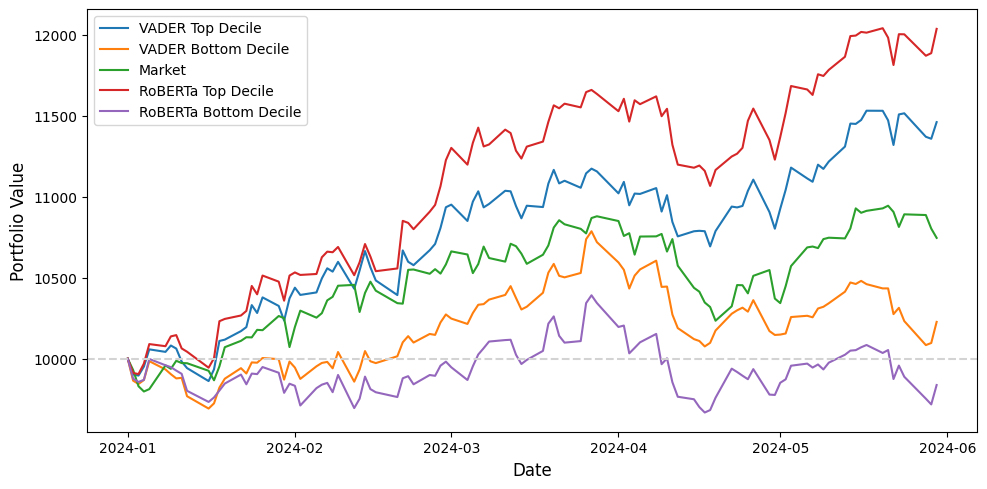

In [99]:
initial_value = 10000

cum_rets_adjusted = (cum_rets + 1) * initial_value

start_date = pd.Period('2024-01-01', freq='D')
start_row = pd.DataFrame([initial_value] * len(cum_rets_adjusted.columns), 
                         index=cum_rets_adjusted.columns).T
start_row.index = [start_date]
cum_rets_adjusted = pd.concat([start_row, cum_rets_adjusted])

plt.figure(figsize=(10, 5))

for col in cum_rets_adjusted.columns:
    plt.plot(cum_rets_adjusted.index.to_timestamp(), cum_rets_adjusted[col], label=col)
    
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value', fontsize=12)
plt.legend()
plt.axhline(y = 10000, color = 'lightgrey', linestyle = '--') 
plt.grid(True)
plt.tight_layout()
plt.grid(visible=False)

# Show the plot
plt.show()

## 5 - Comparison with Sentiment-only Factors

In [100]:
sorts_data

,date,Mkt-RF,SMB,HML,RMW,CMA,RF,ticker,M_vol,M_tot/d,...,roberta_S,vader_S,ret,ret_nd,exc_ret,exc_ret_nd,STF_R,STF_V,STF_R_noisy,STF_V_noisy
9,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.00022,A,0.0,5731.0,...,-0.092790,0.0000,-0.002014,-0.054703,-0.002234,-0.054923,-0.000000,0.000000,7.756701e-10,-3.074126e-10
511,2024-01-03,-0.0101,-0.0194,-0.0011,0.0033,-0.0018,0.00022,A,0.0,5542.0,...,-0.092790,0.0000,-0.054703,-0.001220,-0.054923,-0.001440,-0.000000,0.000000,-6.221702e-10,1.730452e-10
1013,2024-01-04,-0.0033,0.0024,0.0009,-0.0041,0.0024,0.00022,A,1.0,6104.0,...,-0.092790,0.0000,-0.001220,-0.003359,-0.001440,-0.003579,-0.000015,0.000000,-1.520264e-05,1.336891e-10
1515,2024-01-05,0.0015,-0.0059,0.0064,0.0011,-0.0015,0.00022,A,5.0,5824.0,...,-0.242340,0.0116,-0.003359,0.021600,-0.003579,0.021380,-0.000208,0.000010,-2.080537e-04,9.959716e-06
2017,2024-01-08,0.0149,0.0053,-0.0127,-0.0098,-0.0047,0.00022,A,0.0,8911.0,...,-0.242340,0.0116,0.021600,-0.020243,0.021380,-0.020463,-0.000000,0.000000,7.347455e-10,3.700672e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50184,2024-05-23,-0.0085,-0.0066,-0.0065,0.0134,-0.0065,0.00020,ZTS,2.0,14906.0,...,0.076873,0.0000,-0.006684,-0.004857,-0.006884,-0.005057,0.000010,0.000000,1.031508e-05,3.806199e-12
50686,2024-05-24,0.0072,0.0017,0.0016,0.0031,-0.0039,0.00020,ZTS,2.0,8798.0,...,0.576571,0.1350,-0.004857,0.007232,-0.005057,0.007032,0.000131,0.000031,1.310702e-04,3.068739e-05
51188,2024-05-28,-0.0004,0.0010,-0.0089,0.0005,-0.0112,0.00020,ZTS,1.0,10814.0,...,-0.028180,0.0000,0.007232,-0.002919,0.007032,-0.003119,-0.000003,0.000000,-2.606498e-06,-1.471905e-09
51690,2024-05-29,-0.0077,-0.0039,-0.0062,0.0048,-0.0002,0.00020,ZTS,2.0,11793.0,...,0.112318,0.0725,-0.002919,-0.007963,-0.003119,-0.008163,0.000019,0.000012,1.904934e-05,1.229488e-05


In [101]:
deciles_RB_S = sorts_data.sort_values(by='roberta_S', ascending=False)
deciles_RB_S['deciles'] = deciles_RB.groupby(['date'])['roberta_S'].transform(
    lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1
)
deciles_RB_S

,date,Mkt-RF,SMB,HML,RMW,CMA,RF,ticker,M_vol,M_tot/d,...,vader_S,ret,ret_nd,exc_ret,exc_ret_nd,STF_R,STF_V,STF_R_noisy,STF_V_noisy,deciles
17731,2024-02-22,0.0202,-0.0155,-0.0131,0.0040,-0.0118,0.00021,EA,1.0,18031.0,...,0.221,0.016647,-0.006480,0.016437,-0.006690,0.000055,0.000012,5.486296e-05,1.225763e-05,10
32247,2024-04-04,-0.0123,0.0021,0.0016,0.0001,0.0008,0.00021,STZ,1.0,10150.0,...,0.439,-0.009889,0.004994,-0.010099,0.004784,0.000097,0.000043,9.744432e-05,4.325093e-05,10
43820,2024-05-07,0.0005,0.0004,-0.0062,0.0021,0.0024,0.00020,DLTR,1.0,10365.0,...,0.340,0.012398,-0.017260,0.012198,-0.017460,0.000095,0.000033,9.528807e-05,3.280264e-05,10
44322,2024-05-08,-0.0009,-0.0040,0.0057,0.0071,0.0014,0.00020,DLTR,0.0,9389.0,...,0.340,-0.017260,0.004851,-0.017460,0.004651,0.000000,0.000000,-4.882412e-10,7.001505e-10,10
44824,2024-05-09,0.0052,0.0051,0.0038,-0.0001,0.0007,0.00020,DLTR,0.0,8023.0,...,0.340,0.004851,0.007407,0.004651,0.007207,0.000000,0.000000,9.488219e-12,-5.826449e-10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35353,2024-04-12,-0.0153,-0.0037,0.0011,0.0065,-0.0024,0.00021,GPN,1.0,9153.0,...,-0.398,-0.006424,-0.004606,-0.006634,-0.004816,-0.000106,-0.000043,-1.064245e-04,-4.348325e-05,1
26111,2024-03-18,0.0053,-0.0103,-0.0025,0.0020,-0.0013,0.00021,AES,1.0,11514.0,...,-0.561,-0.008661,0.044355,-0.008871,0.044145,-0.000085,-0.000049,-8.476359e-05,-4.872331e-05,1
47093,2024-05-15,0.0115,-0.0046,-0.0022,-0.0042,-0.0038,0.00020,SOLV,1.0,8558.0,...,-0.326,-0.040860,-0.014093,-0.041060,-0.014293,-0.000114,-0.000038,-1.140593e-04,-3.809182e-05,1
50064,2024-05-23,-0.0085,-0.0066,-0.0065,0.0134,-0.0065,0.00020,PPL,0.0,14906.0,...,-0.542,-0.024737,-0.003475,-0.024937,-0.003675,-0.000000,-0.000000,-1.176945e-09,-5.494623e-10,1


In [102]:
portfolios_RB_D_S = compute_deciles_port(deciles_RB_S)
portfolios_RB_D_S['H-L'] = portfolios_RB_D_S['P10'] - portfolios_RB_D_S['P1']
portfolios_RB_D_S.index = pd.to_datetime(portfolios_RB_D_S.index, format="%Y-%m-%d").to_period('D')

In [103]:
portfolios_RB_D_S = portfolios_RB_D_S.sub(rf['RF'], axis=0)
portfolios_RB_D_S_FF = pd.concat([portfolios_RB_D_S, FF_data_analysis], axis=1)
portfolios_RB_D_S_FF

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,,,,,,,,,,,,
2024-01-02,-0.012854,-0.013100,-0.016380,-0.013160,-0.015407,-0.015643,-0.011011,-0.012905,-0.013869,-0.016806,-0.004172,-0.0070,-0.0025,0.0078,0.0070,0.0064
2024-01-03,-0.000483,-0.003833,-0.003519,0.000453,-0.000897,0.000277,-0.001775,-0.003510,-0.000972,-0.001375,-0.001112,-0.0101,-0.0194,-0.0011,0.0033,-0.0018
2024-01-04,0.001235,0.001471,0.001057,0.003496,0.003943,0.003297,0.002013,0.004378,0.001736,0.002326,0.000871,-0.0033,0.0024,0.0009,-0.0041,0.0024
2024-01-05,0.012584,0.009425,0.011544,0.012162,0.011554,0.015874,0.008763,0.012973,0.007223,0.006575,-0.006228,0.0015,-0.0059,0.0064,0.0011,-0.0015
2024-01-08,-0.003411,-0.006495,-0.008226,-0.008404,-0.007960,-0.006423,-0.005036,-0.002431,0.000709,0.000620,0.003810,0.0149,0.0053,-0.0127,-0.0098,-0.0047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-23,0.003527,0.007640,0.009960,0.002801,0.008145,0.002355,0.006300,0.010467,0.007980,0.003066,-0.000662,-0.0085,-0.0066,-0.0065,0.0134,-0.0065
2024-05-24,-0.010836,-0.008800,-0.005751,-0.011413,-0.010151,-0.004878,-0.005461,-0.004357,-0.006730,-0.009977,0.000659,0.0072,0.0017,0.0016,0.0031,-0.0039
2024-05-28,-0.012551,-0.014587,-0.011633,-0.012535,-0.012757,-0.010343,-0.011017,-0.010324,-0.010370,-0.012187,0.000163,-0.0004,0.0010,-0.0089,0.0005,-0.0112


In [104]:
portfolios_RB_D_S.mean()

P1     0.000056
P2     0.000225
P3    -0.000077
P4     0.000150
P5     0.000719
P6     0.000354
P7     0.000760
P8     0.001235
P9     0.000336
P10    0.000185
H-L   -0.000082
dtype: float64

In [105]:
portfolios_RB_D_S.std()

P1     0.007520
P2     0.007575
P3     0.007518
P4     0.007408
P5     0.007617
P6     0.007350
P7     0.007523
P8     0.007175
P9     0.007195
P10    0.007290
H-L    0.003225
dtype: float64

In [106]:
portfolios_RB_D_S.mean()/portfolios_RB_D_S.std()

P1     0.007502
P2     0.029719
P3    -0.010235
P4     0.020184
P5     0.094432
P6     0.048204
P7     0.101061
P8     0.172204
P9     0.046645
P10    0.025343
H-L   -0.025326
dtype: float64

In [107]:
CAPM_RB_S_10 = CAPM_regression(portfolios_RB_D_S, portfolios_RB_D_S_FF)
CAPM_RB_S_10

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha CAPM,0.000017,0.000228,-0.000125,0.000155,0.000713,0.000331,0.000744,0.001187,0.000353,0.000157,-0.00007
Alpha t-stat,0.02293,0.303917,-0.168542,0.211014,0.945774,0.454585,0.999033,1.675452,0.495568,0.217984,-0.21906
β_Mkt-RF,0.054732,-0.003891,0.067049,-0.007275,0.008482,0.032942,0.022791,0.067155,-0.024029,0.038299,-0.016384
Mkt-RF t-stat,0.54709,-0.038554,0.670852,-0.073711,0.083584,0.336562,0.227447,0.70422,-0.250756,0.394631,-0.381602
Adj.R2,-0.006849,-0.009789,-0.005368,-0.00975,-0.009735,-0.008684,-0.009292,-0.004918,-0.009182,-0.008264,-0.008364


In [108]:
FF3_RB_S_10 = FF3_regression(portfolios_RB_D_S, portfolios_RB_D_S_FF)
FF3_RB_S_10

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha FF3,0.000091,0.000292,-0.000099,0.000156,0.000712,0.000354,0.000798,0.001192,0.000394,0.000263,-0.000037
Alpha t-stat,0.120458,0.384359,-0.131053,0.208026,0.928164,0.480011,1.056766,1.652889,0.543773,0.361684,-0.115507
β_Mkt-RF,0.060916,0.012796,0.095015,0.000995,0.028257,0.053423,0.036086,0.084889,-0.026327,0.038013,-0.022887
Mkt-RF t-stat,0.559085,0.11662,0.873445,0.009202,0.254557,0.50018,0.330425,0.813944,-0.251012,0.361119,-0.487783
β_SMB,0.038125,0.018789,-0.018305,-0.009845,-0.025216,-0.010714,0.017013,-0.019289,0.028609,0.06629,0.02827
SMB t-stat,0.354216,0.173338,-0.170343,-0.092172,-0.229954,-0.101541,0.157698,-0.187229,0.276137,0.637493,0.609918
β_HML,0.109143,0.144258,0.152777,0.03726,0.086097,0.116703,0.118582,0.083153,0.035891,0.116566,0.007384
HML t-stat,0.800435,1.050515,1.122236,0.275345,0.619768,0.873088,0.867633,0.637096,0.273443,0.88485,0.125745
Adj.R2,-0.01418,-0.013686,-0.011409,-0.029154,-0.025964,-0.02006,-0.018115,-0.020761,-0.026589,-0.007315,-0.022744


In [109]:
FF5_RB_S_10 = FF5_regression(portfolios_RB_D_S, portfolios_RB_D_S_FF)
FF5_RB_S_10

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha FF5,0.000159,0.000354,-0.000046,0.000235,0.000761,0.000409,0.000842,0.001223,0.000455,0.000324,-0.000045
Alpha t-stat,0.212683,0.466619,-0.060711,0.318626,0.992,0.552042,1.113664,1.682085,0.628988,0.446882,-0.136758
β_Mkt-RF,0.19833,0.054008,0.211763,0.126151,0.134184,0.098943,0.134509,0.113377,0.06956,0.138252,-0.060141
Mkt-RF t-stat,1.475732,0.395011,1.566944,0.948438,0.970248,0.74178,0.987092,0.865353,0.534082,1.058179,-1.022866
β_SMB,-0.093365,-0.099941,-0.121257,-0.163208,-0.120435,-0.113964,-0.069047,-0.078946,-0.087569,-0.050865,0.042739
SMB t-stat,-0.708615,-0.745598,-0.915199,-1.251595,-0.88826,-0.871494,-0.516841,-0.614617,-0.685807,-0.397113,0.741439
β_HML,0.022692,0.150849,0.075734,-0.027699,0.016937,0.112545,0.053332,0.078516,-0.014418,0.062212,0.039507
HML t-stat,0.146079,0.954548,0.484835,-0.180172,0.105955,0.729994,0.338604,0.518469,-0.095773,0.411968,0.581322
β_RMW,-0.126354,-0.231818,-0.085921,-0.197259,-0.082383,-0.187841,-0.070643,-0.105424,-0.147903,-0.144109,-0.017539
RMW t-stat,-0.682938,-1.231613,-0.461824,-1.077274,-0.432705,-1.022949,-0.376574,-0.584493,-0.824891,-0.801219,-0.216685


All 3 risk-adjusted models signal that the $\alpha$ is negative and not statistically significant, meaning it is not possible to reject the hypothesis that it is different from zero.

In [110]:
S_graph = portfolios_RB_D_S[['P10', 'P1']]
BERT_graph = portfolios_RB_D_FF[['P10', 'P1', 'Mkt-RF']] 

S_cum_S = cumulative_ret(S_graph)
BERT_cum_S = cumulative_ret(BERT_graph)

S_cum_S = S_cum_S.rename(columns={'P10':'S Top Decile', 'P1':'S Bottom Decile'})
BERT_cum_S = BERT_cum_S.rename(columns={'P10':'AxS Top Decile', 'P1':'AxS Bottom Decile', 'Mkt-RF':'Market'})

cum_rets_S = pd.merge(S_cum_S, BERT_cum_S, left_index=True, right_index=True)
cum_rets_S

,S Top Decile,S Bottom Decile,AxS Top Decile,AxS Bottom Decile,Market
date,,,,,
2024-01-02,-0.016806,-0.012854,-0.008841,-0.012345,-0.007000
2024-01-03,-0.018158,-0.013331,-0.009506,-0.014389,-0.017029
2024-01-04,-0.015874,-0.012112,-0.003044,-0.013051,-0.020273
2024-01-05,-0.009403,0.000319,0.009005,-0.000175,-0.018804
2024-01-08,-0.008789,-0.003093,0.007703,-0.004077,-0.004184
...,...,...,...,...,...
2024-05-23,0.019338,0.012242,0.200343,-0.004270,0.081340
2024-05-24,0.009168,0.001273,0.200278,-0.011176,0.089125
2024-05-28,-0.003131,-0.011294,0.187053,-0.024710,0.088690


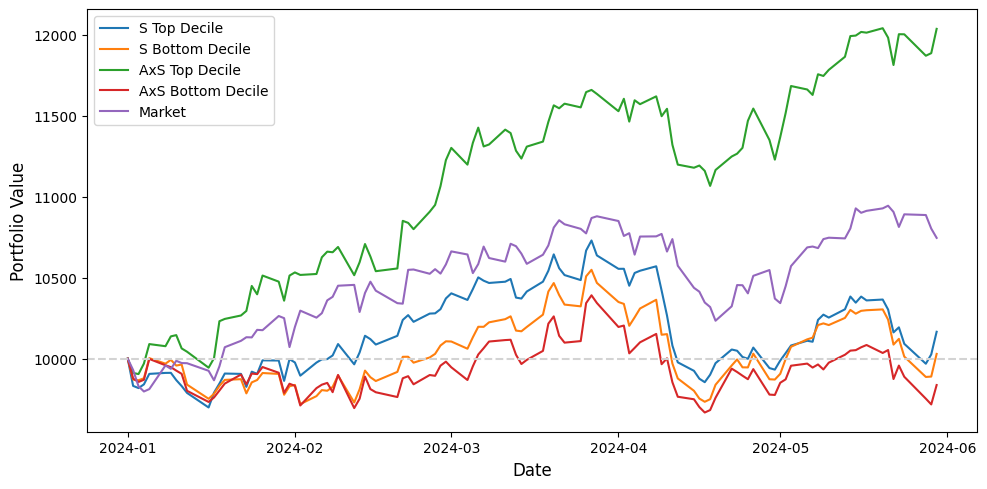

In [111]:
initial_value = 10000

cum_rets_adjusted_S = (cum_rets_S + 1) * initial_value

start_date = pd.Period('2024-01-01', freq='D')
start_row = pd.DataFrame([initial_value] * len(cum_rets_adjusted_S.columns), 
                         index=cum_rets_adjusted_S.columns).T
start_row.index = [start_date]
cum_rets_adjusted_S = pd.concat([start_row, cum_rets_adjusted_S])

plt.figure(figsize=(10, 5))

for col in cum_rets_adjusted_S.columns:
    plt.plot(cum_rets_adjusted_S.index.to_timestamp(), cum_rets_adjusted_S[col], label=col)
    
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value', fontsize=12)
plt.legend()
plt.axhline(y = 10000, color = 'lightgrey', linestyle = '--') 
plt.grid(True)
plt.tight_layout()
plt.grid(visible=False)

# Show the plot
plt.show()

#### Quintiles

In [112]:
quintiles_RB_S = sorts_data.sort_values(by='roberta_S', ascending=False)
quintiles_RB_S['quintiles'] = deciles_RB.groupby(['date'])['roberta_S'].transform(
    lambda x: pd.qcut(x, 5, labels=False, duplicates='drop') + 1
)

In [113]:
portfolios_RB_Q_S = compute_quintiles_port(quintiles_RB_S)
portfolios_RB_Q_S['H-L'] = portfolios_RB_Q_S['P5'] - portfolios_RB_Q_S['P1']
portfolios_RB_Q_S.index = pd.to_datetime(portfolios_RB_Q_S.index, format="%Y-%m-%d").to_period('D')

In [114]:
portfolios_RB_Q_S = portfolios_V_Q.sub(rf['RF'], axis=0)
portfolios_RB_Q_S_FF = pd.concat([portfolios_RB_Q_S, FF_data_analysis], axis=1)
portfolios_RB_Q_S_FF

,P1,P2,P3,P4,P5,H-L,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,,,,,,,
2024-01-02,-0.016553,-0.014170,-0.015256,-0.012429,-0.013222,0.002891,-0.0070,-0.0025,0.0078,0.0070,0.0064
2024-01-03,-0.002149,-0.000620,-0.001874,-0.001875,-0.002369,-0.000659,-0.0101,-0.0194,-0.0011,0.0033,-0.0018
2024-01-04,0.002520,0.001081,0.002483,0.000728,0.004526,0.001566,-0.0033,0.0024,0.0009,-0.0041,0.0024
2024-01-05,0.012444,0.010488,0.010953,0.008431,0.010824,-0.002060,0.0015,-0.0059,0.0064,0.0011,-0.0015
2024-01-08,-0.004420,-0.005428,-0.008104,-0.002607,-0.004053,-0.000074,0.0149,0.0053,-0.0127,-0.0098,-0.0047
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-23,0.005664,0.002931,0.003407,0.007273,0.010858,0.004794,-0.0085,-0.0066,-0.0065,0.0134,-0.0065
2024-05-24,-0.010753,-0.010897,-0.009665,-0.006377,-0.002531,0.007822,0.0072,0.0017,0.0016,0.0031,-0.0039
2024-05-28,-0.013143,-0.011805,-0.012355,-0.011567,-0.011301,0.001442,-0.0004,0.0010,-0.0089,0.0005,-0.0112


In [115]:
portfolios_RB_Q_S.mean()

P1     0.000017
P2     0.000220
P3     0.000181
P4    -0.000097
P5     0.000598
H-L    0.000161
dtype: float64

In [116]:
portfolios_RB_Q_S.std()

P1     0.007119
P2     0.007292
P3     0.007326
P4     0.007002
P5     0.007500
H-L    0.003358
dtype: float64

In [117]:
portfolios_RB_Q_S.mean()/portfolios_RB_Q_S.std()

P1     0.002422
P2     0.030133
P3     0.024729
P4    -0.013855
P5     0.079739
H-L    0.047894
dtype: float64

1) **CAPM**

In [118]:
CAPM_RB_S_5 = CAPM_regression(portfolios_RB_Q_S, portfolios_RB_Q_S_FF)
CAPM_RB_S_5

,P1,P2,P3,P4,P5,H-L
Alpha CAPM,-0.00002,0.000225,0.000146,-0.000122,0.000598,0.000198
Alpha t-stat,-0.028239,0.311089,0.201856,-0.175767,0.805677,0.599725
β_Mkt-RF,0.051607,-0.006742,0.048581,0.034409,-0.000264,-0.051772
Mkt-RF t-stat,0.544908,-0.069401,0.498295,0.36908,-0.002642,-1.16488
Adj.R2,-0.006873,-0.009756,-0.007352,-0.008457,-0.009804,0.003454


2) **FF-3 Factors**

In [119]:
FF3_RB_S_5 = FF3_regression(portfolios_RB_Q_S, portfolios_RB_Q_S_FF)
FF3_RB_S_5

,P1,P2,P3,P4,P5,H-L
Alpha FF3,-0.000008,0.000252,0.000186,-0.000049,0.000644,0.000231
Alpha t-stat,-0.010708,0.343312,0.252704,-0.069681,0.852987,0.689333
β_Mkt-RF,0.072155,0.012255,0.056605,0.041825,0.008286,-0.063839
Mkt-RF t-stat,0.697556,0.115592,0.531255,0.412428,0.075905,-1.314326
β_SMB,-0.018015,-0.006853,0.014821,0.036106,0.017598,0.035823
SMB t-stat,-0.1763,-0.065436,0.140807,0.360425,0.163203,0.746605
β_HML,0.104098,0.113756,0.079709,0.113708,0.088154,-0.016022
HML t-stat,0.804149,0.857365,0.597771,0.895961,0.645317,-0.263583
Adj.R2,-0.020009,-0.021201,-0.021768,-0.013298,-0.023187,-0.010788


3) **FF-5 Factors**

In [120]:
FF5_RB_S_5 = FF5_regression(portfolios_RB_Q_S, portfolios_RB_Q_S_FF)
FF5_RB_S_5

,P1,P2,P3,P4,P5,H-L
Alpha FF5,0.00005,0.000332,0.000255,-0.0,0.000671,0.000201
Alpha t-stat,0.069478,0.457584,0.348293,-0.00033,0.883425,0.600807
β_Mkt-RF,0.153905,0.111301,0.166535,0.116938,0.090317,-0.063714
Mkt-RF t-stat,1.195743,0.851892,1.263548,0.924171,0.660273,-1.057093
β_SMB,-0.128048,-0.16038,-0.11728,-0.057439,-0.035271,0.093255
SMB t-stat,-1.014765,-1.252105,-0.90764,-0.463029,-0.263011,1.578178
β_HML,0.065712,0.075537,0.021585,0.075338,0.026037,-0.039702
HML t-stat,0.441704,0.500201,0.141687,0.515125,0.164683,-0.569893
β_RMW,-0.15296,-0.234753,-0.166891,-0.122064,-0.012758,0.140633
RMW t-stat,-0.863251,-1.30518,-0.919798,-0.700736,-0.067753,1.694872


### All Portfolios Cumulative Returns

In [121]:
S_only_cum_rest = cumulative_ret(portfolios_RB_D_S)
S_only_cum_rest

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
date,,,,,,,,,,,
2024-01-02,-0.012854,-0.013100,-0.016380,-0.013160,-0.015407,-0.015643,-0.011011,-0.012905,-0.013869,-0.016806,-0.004172
2024-01-03,-0.013331,-0.016882,-0.019842,-0.012713,-0.016290,-0.015371,-0.012767,-0.016369,-0.014827,-0.018158,-0.005279
2024-01-04,-0.012112,-0.015436,-0.018806,-0.009261,-0.012412,-0.012124,-0.010780,-0.012063,-0.013118,-0.015874,-0.004413
2024-01-05,0.000319,-0.006157,-0.007478,0.002788,-0.001001,0.003557,-0.002112,0.000753,-0.005989,-0.009403,-0.010614
2024-01-08,-0.003093,-0.012612,-0.015643,-0.005639,-0.008953,-0.002888,-0.007137,-0.001680,-0.005285,-0.008789,-0.006844
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-23,0.012242,0.025826,-0.005732,0.019349,0.081057,0.031318,0.072984,0.127381,0.033574,0.019338,-0.014645
2024-05-24,0.001273,0.016799,-0.011451,0.007715,0.070084,0.026287,0.067124,0.122469,0.026618,0.009168,-0.013996
2024-05-28,-0.011294,0.001967,-0.022951,-0.004917,0.056433,0.015673,0.055368,0.110881,0.015971,-0.003131,-0.013835


These comulative returns, align with the alpga findings, and confirm that not only the strategy is not profitable (even without accounting for transaction costs), but also that it is indeed less profitable than the one based on the $Attention \times Sentiment$.

A x S Roberta Cum Rets

In [122]:
P10_R_cum_rets = cumulative_ret(portfolios_RB_D)
P10_R_cum_rets

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
date,,,,,,,,,,,
2024-01-02,-0.012345,-0.015814,-0.008910,-0.015375,-0.020117,-0.019305,-0.012264,-0.015112,-0.013020,-0.008841,0.003284
2024-01-03,-0.014389,-0.019384,-0.010124,-0.017273,-0.021463,-0.018265,-0.011895,-0.018117,-0.016032,-0.009506,0.004466
2024-01-04,-0.013051,-0.018366,-0.007727,-0.015598,-0.018137,-0.017779,-0.008529,-0.013797,-0.015860,-0.003044,0.009435
2024-01-05,-0.000175,-0.009542,0.003065,-0.004726,-0.006149,-0.006493,0.004452,-0.005642,-0.008597,0.009005,0.008243
2024-01-08,-0.004077,-0.014219,-0.005679,-0.010450,-0.012730,-0.012919,-0.000488,-0.012788,-0.006204,0.007703,0.010655
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-23,-0.004270,-0.009826,0.037927,0.019368,0.022221,0.059705,0.067949,0.000130,0.031155,0.200343,0.178899
2024-05-24,-0.011176,-0.016111,0.025154,0.005250,0.008695,0.049096,0.060579,-0.003617,0.025923,0.200278,0.186776
2024-05-28,-0.024710,-0.026500,0.012467,-0.004870,-0.006499,0.036443,0.047708,-0.012298,0.012937,0.187053,0.189705


A x S VADER Cum Rets

In [123]:
P10_V_cum_rets = cumulative_ret(portfolios_V_D)
P10_V_cum_rets

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
date,,,,,,,,,,,
2024-01-02,-0.013582,-0.019084,-0.012548,-0.015323,-0.017488,-0.012534,-0.011966,-0.012457,-0.016214,-0.009790,0.003572
2024-01-03,-0.015618,-0.020844,-0.011290,-0.017333,-0.019255,-0.014023,-0.014674,-0.012997,-0.019812,-0.010424,0.004780
2024-01-04,-0.013182,-0.017902,-0.008334,-0.017680,-0.014778,-0.013230,-0.014822,-0.010955,-0.015982,-0.004898,0.007683
2024-01-05,-0.001545,-0.004609,0.000556,-0.005485,-0.004288,-0.001675,-0.007572,-0.001095,-0.004772,0.005745,0.006356
2024-01-08,-0.006658,-0.007872,-0.004247,-0.011061,-0.012592,-0.009082,-0.012847,-0.000495,-0.010868,0.004194,0.009737
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-23,0.031395,0.025950,0.038489,0.050015,0.032647,0.043812,-0.002682,0.021512,0.024986,0.150811,0.092002
2024-05-24,0.023191,0.012457,0.026255,0.039920,0.023943,0.032830,-0.009403,0.015775,0.019593,0.151501,0.101125
2024-05-28,0.008384,0.000901,0.013384,0.028826,0.012606,0.019134,-0.022454,0.006066,0.009786,0.137011,0.102983


#### Quintiles Cumulative Returns

Sentiment-only RoBERTa

In [124]:
P5_RB_S_cum_rets = cumulative_ret(portfolios_RB_Q_S)
P5_RB_S_cum_rets

,P1,P2,P3,P4,P5,H-L
date,,,,,,
2024-01-02,-0.016553,-0.014170,-0.015256,-0.012429,-0.013222,0.002891
2024-01-03,-0.018666,-0.014781,-0.017102,-0.014280,-0.015559,0.002229
2024-01-04,-0.016194,-0.013716,-0.014661,-0.013563,-0.011104,0.003799
2024-01-05,-0.003951,-0.003372,-0.003868,-0.005246,-0.000401,0.001731
2024-01-08,-0.008354,-0.008782,-0.011941,-0.007840,-0.004452,0.001657
...,...,...,...,...,...,...
2024-05-23,0.007376,0.022563,0.016647,-0.011598,0.063882,0.012442
2024-05-24,-0.003456,0.011420,0.006822,-0.017901,0.061189,0.020362
2024-05-28,-0.016554,-0.000520,-0.005618,-0.029261,0.049197,0.021833


 Roberta

In [125]:
P5_RB_cum_rets = cumulative_ret(portfolios_RB_Q)
P5_RB_cum_rets

,P1,P2,P3,P4,P5,H-L
date,,,,,,
2024-01-02,-0.014080,-0.012175,-0.019715,-0.013673,-0.010931,0.002929
2024-01-03,-0.016888,-0.013736,-0.019881,-0.014977,-0.012771,0.003699
2024-01-04,-0.015710,-0.011705,-0.017958,-0.011137,-0.009465,0.005637
2024-01-05,-0.004866,-0.000872,-0.006318,-0.000551,0.000176,0.004124
2024-01-08,-0.009157,-0.008085,-0.012822,-0.006589,0.000738,0.008797
...,...,...,...,...,...,...
2024-05-23,-0.006882,0.028649,0.040681,0.033933,0.112981,0.096743
2024-05-24,-0.013478,0.015196,0.028570,0.028429,0.110128,0.100996
2024-05-28,-0.025437,0.003804,0.014605,0.017708,0.096985,0.101089


VADER

In [126]:
P5_V_cum_rets = cumulative_ret(portfolios_V_Q)
P5_V_cum_rets

,P1,P2,P3,P4,P5,H-L
date,,,,,,
2024-01-02,-0.016333,-0.013950,-0.015036,-0.012209,-0.013002,0.003111
2024-01-03,-0.018231,-0.014344,-0.016666,-0.013843,-0.015123,0.002670
2024-01-04,-0.015541,-0.013062,-0.014007,-0.012909,-0.010449,0.004461
2024-01-05,-0.003074,-0.002494,-0.002991,-0.004370,0.000480,0.002612
2024-01-08,-0.007260,-0.007689,-0.010851,-0.006746,-0.003356,0.002759
...,...,...,...,...,...,...
2024-05-23,0.028793,0.044299,0.038259,0.009420,0.086488,0.033964
2024-05-24,0.017936,0.033128,0.028432,0.003184,0.083955,0.042259
2024-05-28,0.004761,0.021139,0.015932,-0.008219,0.071922,0.043970


#### Market

In [128]:
mkt = portfolios_RB_D_FF['Mkt-RF']

In [129]:
mkt.mean()

0.0007192307692307691

In [130]:
mkt.std()

0.007431474352578003

In [131]:
mkt.mean()/mkt.std()

0.09678170644311859